# <center> Модель ML - временной ряд акции с Yahoo finance.
Yahoo Finance - один из самых популярных сайтов в мире финансов, который предоставляет нам данные в режиме онлайн и исторические: новости из мира финансов, статьи от экспертов на тему бизнеса и экономики, анализ компаний, рейтинги лучших активов, актуальные котировки, финансовые отчёты различных организаций, скринер акций и многое другое.\
Мы не претендуем на столько экспертное мнение, каким обладает данный сайт, но если вы 'чайник' в мире бирж, трейдинга, рынка акций, 
каким в данном случае является автор данного проекта, то для вас предлагается отследить динамику выбранной акции за последние несколько лет и принять решение на основе прогноза модели, инвестировать ли в данную акцию.

Можно выделить три подхода в прогнозировании акций:
1) Фундаментальный - в данном случае оценивается вся информация, которая относится к компании: вся предыдущая деятельность
компании, динамика развития оборота и прибыли, движения дивидендов, анализ всех активов компании, включая финансовые отчеты.
2) Технический - динамика стоимости акции (то есть анализ временных рядов). Именно данный подход лежит в основе нашей модели. Мы попробуем построить алгоритм ML, который будет определять поведение акции во времени и прогнозировать.
3) Гибридный - сочетание фундаментального и технического подходов.

Прежде всего, наша модель очень проста, она может предсказать только одну выбранную акцию за раз: для этого вам необходимо ввести тикер акции, так называемое краткое название акции, облигации или другой ценной бумаги.\
Примеры тикеров: Alphabet Inc (материнская компания Google) код GOOG, тикер Apple Inc — это AAPL,  Amazon — AMZN, Alibaba Group Holding - BABA, NVIDIA - NVDA.

После ввода тикера акции любой компании, представленной американским финансовым провайдером Yahoo finance, вы увидите всю техническую аналитику динамики развития данной акции за последние 7 лет.\
Для более объективного прогнозирования мы построим несколько моделей врменного ряда, сравним с помощью метрики MAPE(средняя абсолютная ошибка в процентах) качество моделей и выберем наиболее эффективную.

Наша задача всего лишь познакомить вас с внутренней background составляющей любого прогноза временного ряда на будущее, единственное крайне важное замечание: часто на изменение акции влияют внешние факторы (новости, изменения в экономике, политике, глобальные события), которые мы в данном случае не учитываем, потому что это уже другая задача, которую мы оставим для следующего исследования.

Для нашего примера мы возьмем гиганта в мире производства IT технологий Intel Corporation - тикер INTC.\
Обязательно поэкспериментируйте с разными активами, но точность прогнозирования у разных акций может достаточно отличаться в зависимости от сложности поведения акции, ее волатильности, внешних факторов. 

Переходим по ссылке, в ней отражена вся [визуализация в проекте](https://nbviewer.org/github/YaroslavaVob/DataScience/blob/c45bd8976434d7f78ce1126b3154a0583e7e585a/Final_project_1_year/Project.ipynb).

Импортируем необходимые для создания модели пакеты

In [1]:
# инструмент для получения информации с ресурса Yahoo finance, библиотека не является аффилированной
# !pip install yfinance
import yfinance as yf                                      

from datetime import datetime, timedelta                   # встроеный модуль python для обработки времени и даты
from dateutil.relativedelta import relativedelta           # пакет, расширяющий методы модуля datetime

import pandas as pd                                        # библиотека для анализа и обработки данных
import numpy as np                                         # библиотека для матричных вычислений

# пакеты для визуализации данных, графическом отображении факторов и их зависимостей
import matplotlib.pyplot as plt                              
%matplotlib inline
import seaborn as sns                                        
import plotly.graph_objects as go                          # интерактивная визуализации данных 
import plotly.express as px
from plotly.subplots import make_subplots                  # для создания многоуровневых графиков

# библиотека статистических тестов, инструментов оценки различных моделей и исследования данных
import statsmodels as sm                                     
from statsmodels.tsa.seasonal import seasonal_decompose    # инструмент декомпозиции временного ряда
from statsmodels.tsa.stattools import adfuller             # тест Дики-Фулера на стационарность временного ряда
from statsmodels.tsa.arima.model import ARIMA              # интегрированная модель авторегрессии — скользящего среднего

from sklearn.metrics import mean_absolute_percentage_error # метрика оценки качества модели - средняя абсолютная ошибка в процентах
from sklearn.model_selection import GridSearchCV           # алгоритм для поиска наилучших гиперпараметров по сетке

# библиотека для временных рядов на основе алгоритма ARIMA с функцией автоматического подбора лучших гиперпараметров для моделирования
import pmdarima as pm                                        
# обобщенная авторегрессионная модель условной гетероскедастичности
from arch import arch_model                                  

# библиотека для задач ML, связанных с регуляризацией градиентного бустинга
import xgboost as xgb  

# нейронная сеть для прогнозирования временных рядов (потомок Prophet от facebook)
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, set_log_level   # воспроизводимость одинакового результата и установка уровня логирования для обучения модели

import warnings
warnings.filterwarnings('ignore')
# отображение графиков в режиме оффлайн
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default='notebook'

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


### 1. Загрузка данных выбранной акции и общий анализ.

In [2]:
x = input('Введите тикер акции заглавными буквами на английском языке (например, AAPL, NVDA, GOOG, AMD, TSLA, INTC),\
          название акции компании должно соотвествовать символу на сайте finance.yahoo.com:')

##### 1.1 Краткая информация об акции

In [3]:
# загружаем название компании, соотвествующей тикеру
try:
    # находим полное название компании по ключу longName
    stock = yf.Ticker(x).info['longName']
except:
    print('В текущий момент ошибка доступа, попробуйте еще раз')
# создаем список наименований-ключей, с помощью которых получим общую информацию о компании
presentation = ['website', 'industry', 'sector', 'currentRatio', 'currentPrice', 'revenueGrowth']
# создаем пустой список для добавления в него общих данных о компании 
lst = []
for info in presentation:
    lst.append(yf.Ticker(x).info[info])
print(f'{stock}:\n сайт компании: {lst[0]}\n сфера дятельности: {lst[1], lst[2]}\n коэффициент текущей ликвидности: {lst[3]}\n текущая стоимость акции: {lst[4]}\n рост доходов: {lst[5]}%')

Intel Corporation:
 сайт компании: https://www.intel.com
 сфера дятельности: ('Semiconductors', 'Technology')
 коэффициент текущей ликвидности: 1.587
 текущая стоимость акции: 19.951
 рост доходов: -0.009%


In [4]:
# вычисляем дату начала интересующего нас периода движения акции: из текущей даты вычитаем 7-летний период
start_date = datetime.now() - relativedelta(years=7)
# крайняя дата данных - предыдущий день
end_date = datetime.now() - timedelta(days=1)
# загружаем данные
stock_data = yf.download(x, start=start_date, end=end_date, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [5]:
# посмотрим на первые несколько строк динамики акции
stock_data.head(7)

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-09-05  35.020000  35.330002  34.930000  35.020000  29.225954  18772000
2017-09-06  35.220001  35.939999  35.110001  35.759998  29.843513  28076400
2017-09-07  35.880001  35.950001  35.330002  35.540001  29.659916  16297100
2017-09-08  35.419998  35.540001  35.080002  35.189999  29.367825  14125000
2017-09-11  35.490002  36.000000  35.139999  35.770000  29.851864  20037600
2017-09-12  35.880001  36.340000  35.740002  36.090000  30.118919  19489900
2017-09-13  36.000000  36.400002  35.970001  36.330002  30.319210  15509800

Итак, динамика движения акции содержит следующие показатели:
* Date - ежедневные даты трейдинга акции, экономические биржы работают с понедельника по пятницу
* Open - стоимость акции на момент открытия торгов
* High - максимальная стоимость акции за время торгов
* Low - минимальная стоимость акции за время торгов
* Close - стоимость акции на момент закрытия торгов
* Adj Close - скорректированная стоимость акции закрытия, которая учитывает любые корпоративных действий и события, происходящие до открытия торгов на следующей день
* Volume - количество финансовых активов, которые были куплены или проданы за один день

##### 1.2 Общий обзор

In [6]:
# количество значений в данных и типы данных
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1760 entries, 2017-09-05 to 2024-09-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1760 non-null   float64
 1   High       1760 non-null   float64
 2   Low        1760 non-null   float64
 3   Close      1760 non-null   float64
 4   Adj Close  1760 non-null   float64
 5   Volume     1760 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.2 KB


In [7]:
# общие статистические данные
stock_data.describe()

Open         High          Low        Close    Adj Close  \
count  1760.000000  1760.000000  1760.000000  1760.000000  1760.000000   
mean     45.899295    46.479563    45.324131    45.904301    41.635972   
std      10.352626    10.442777    10.264864    10.358900     8.521750   
min      19.100000    19.969999    18.840000    18.990000    18.990000   
25%      37.619999    38.082499    37.067501    37.682501    35.334602   
50%      47.550001    48.220001    46.929998    47.625000    42.356277   
75%      53.235000    53.892500    52.762499    53.307500    47.530927   
max      68.199997    69.290001    67.309998    68.470001    62.083336   

             Volume  
count  1.760000e+03  
mean   3.392600e+07  
std    1.905880e+07  
min    6.313200e+06  
25%    2.198762e+07  
50%    2.971785e+07  
75%    3.985542e+07  
max    3.008959e+08

Основное, что мы изучаем в статистических показателях, это выбросы, мы сравниваем среднее значение каждого показателя и медианное и, если они близки или совпадают, то выбросов нет, если разнятся, это указывает на высокую волатильность, также мы можем оценить минимальное и максимальное значения, чтобы понять, насколько колебалась акция последние годы, это также можно заметить по значению стандартного отклонения.

In [8]:
# проверка на пропуски
stock_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## 2. Разведывательный анализ данных с визуализацией
### 2.1 Создание дополнительных факторов
* Сгенерируем признак разницы цены акции в момент открытия и закрытия торгов
* Признак года
* Признак месяца
* Признак дня недели

Интересно проследить, в какие месяцы и дни недели чаще всего наблюдается рост акции, а в какие лучше не продавать, а именно покупать акции, потому что она упала в цене и затем скорее всего будет рост, возможна ли цикличность.

In [9]:
# создаем признак разницы цены акции в день торгов
stock_data['Diff'] = stock_data.Open-stock_data.Close
stock_data.head()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2017-09-05  35.020000  35.330002  34.930000  35.020000  29.225954  18772000   
2017-09-06  35.220001  35.939999  35.110001  35.759998  29.843513  28076400   
2017-09-07  35.880001  35.950001  35.330002  35.540001  29.659916  16297100   
2017-09-08  35.419998  35.540001  35.080002  35.189999  29.367825  14125000   
2017-09-11  35.490002  36.000000  35.139999  35.770000  29.851864  20037600   

                Diff  
Date                  
2017-09-05  0.000000  
2017-09-06 -0.539997  
2017-09-07  0.340000  
2017-09-08  0.230000  
2017-09-11 -0.279999

In [10]:
# дублируем индексы-даты в столбец
stock_data['Date'] = pd.to_datetime(stock_data.index, errors='coerce')
# из даты-признака извлекает год, месяц и день недели в раздельные столбцы с помощью аргумента dt
stock_data['year'] = stock_data['Date'].dt.year
stock_data['month'] = stock_data['Date'].dt.month_name(locale='English')
stock_data['week'] = stock_data['Date'].dt.day_name()
# удаляем преобразованный признак-дату
stock_data = stock_data.drop('Date', axis=1)
stock_data.head(6)

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2017-09-05  35.020000  35.330002  34.930000  35.020000  29.225954  18772000   
2017-09-06  35.220001  35.939999  35.110001  35.759998  29.843513  28076400   
2017-09-07  35.880001  35.950001  35.330002  35.540001  29.659916  16297100   
2017-09-08  35.419998  35.540001  35.080002  35.189999  29.367825  14125000   
2017-09-11  35.490002  36.000000  35.139999  35.770000  29.851864  20037600   
2017-09-12  35.880001  36.340000  35.740002  36.090000  30.118919  19489900   

                Diff  year      month       week  
Date                                              
2017-09-05  0.000000  2017  September    Tuesday  
2017-09-06 -0.539997  2017  September  Wednesday  
2017-09-07  0.340000  2017  September   Thursday  
2017-09-08  0.230000  2017  September     Friday  
2017-09-11 -0.279999  2017  September     Monday  
2017-09-12 -0.209999  2017  September    Tuesday

### 2.2 Динамика показателей акции во времени
**2.2.1 График торгов акции OHLC**\
Демонстрирует два диапазона показателей: максимальную и минимальную цену торгов, а также цену открытия и цену закрытия за анализируемый период времени. Если цена закрытия выше, чем цена открытия - зеленый цвет (т.н. 'бычий' рынок), в случае, когда  цена закрытия ниже, чем цена открытия - красный цвет ('медвежий' рынок).

In [11]:
# создаем координатную плоскость
# педедаем в качестве аргументов признаки: Open, High, Low, Close
fig = go.Figure(data=go.Ohlc(x=stock_data.index,
                open=stock_data['Open'],
                high=stock_data['High'],
                low=stock_data['Low'],
                close=stock_data['Close'],
                increasing_line_color= 'green', decreasing_line_color= 'tomato')) # зеленый - рост акции в день торгов, красный - падение
fig.update_layout(
    title={'text': f"OHLC of stock {x}",'x':0.5,'xanchor': 'center', 'yanchor': 'top'}, # название графика и расположение
    width=1000, height=500,                                                             # размеры графика
    autosize=False, margin=dict(t=30, b=30, l=30, r=10),                                # отступы от плоскости
    template='plotly'                                                                   # стиль(цвет, сетка)
)
fig.write_image('images/Chart OHLC.png', engine='kaleido')                              # сохранение графика
iplot(fig)

По графику OHLC для акции INTC мы видим, что преобдалает "медвежий" рынок, а также можно отметить резкие колебания, что говорит о частой высокой волатильности данного актива, в последнее время цена акции "просела", причем резким падением.

**2.2.2 График динамики торгового оборота актива за весь исследуемый период**

In [12]:
# создаем плоскость с двумя подграфиками
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_heights=[2, 1])
# линейный график движение оборота торгов
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.Volume, name='Time series of Volume'),row=1, col=1)
fig.update_traces(line_color='magenta', line_width=0.8)  # задаем цвет и ширину линии
# линейный график динамики скорректированной стоимости акции
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], name='Time series of Closing Price'), row=2, col=1)
fig.update_traces(line_color='blue', line_width=1, row=2, col=1)  # задаем цвет и ширину линии
fig.update_layout(
    title={'text': f'Comparison of volume and price dynamics','x':0.5,'xanchor': 'center', 'yanchor': 'top'}, 
    width=1000, height=500,
    autosize=False, margin=dict(t=30, b=60, l=30, r=10),
    template="plotly",
    legend=dict(yanchor="bottom", y=-0.2, orientation='h', xanchor="right", x=0.9)
    )
fig.write_image('images/Comparison of volume and price dynamics.png')                    # сохранение графика
iplot(fig)

**2.2.3 Распределение положительной и отрицательной разницы ежедневных торгов акций по дням недели и месяцам**

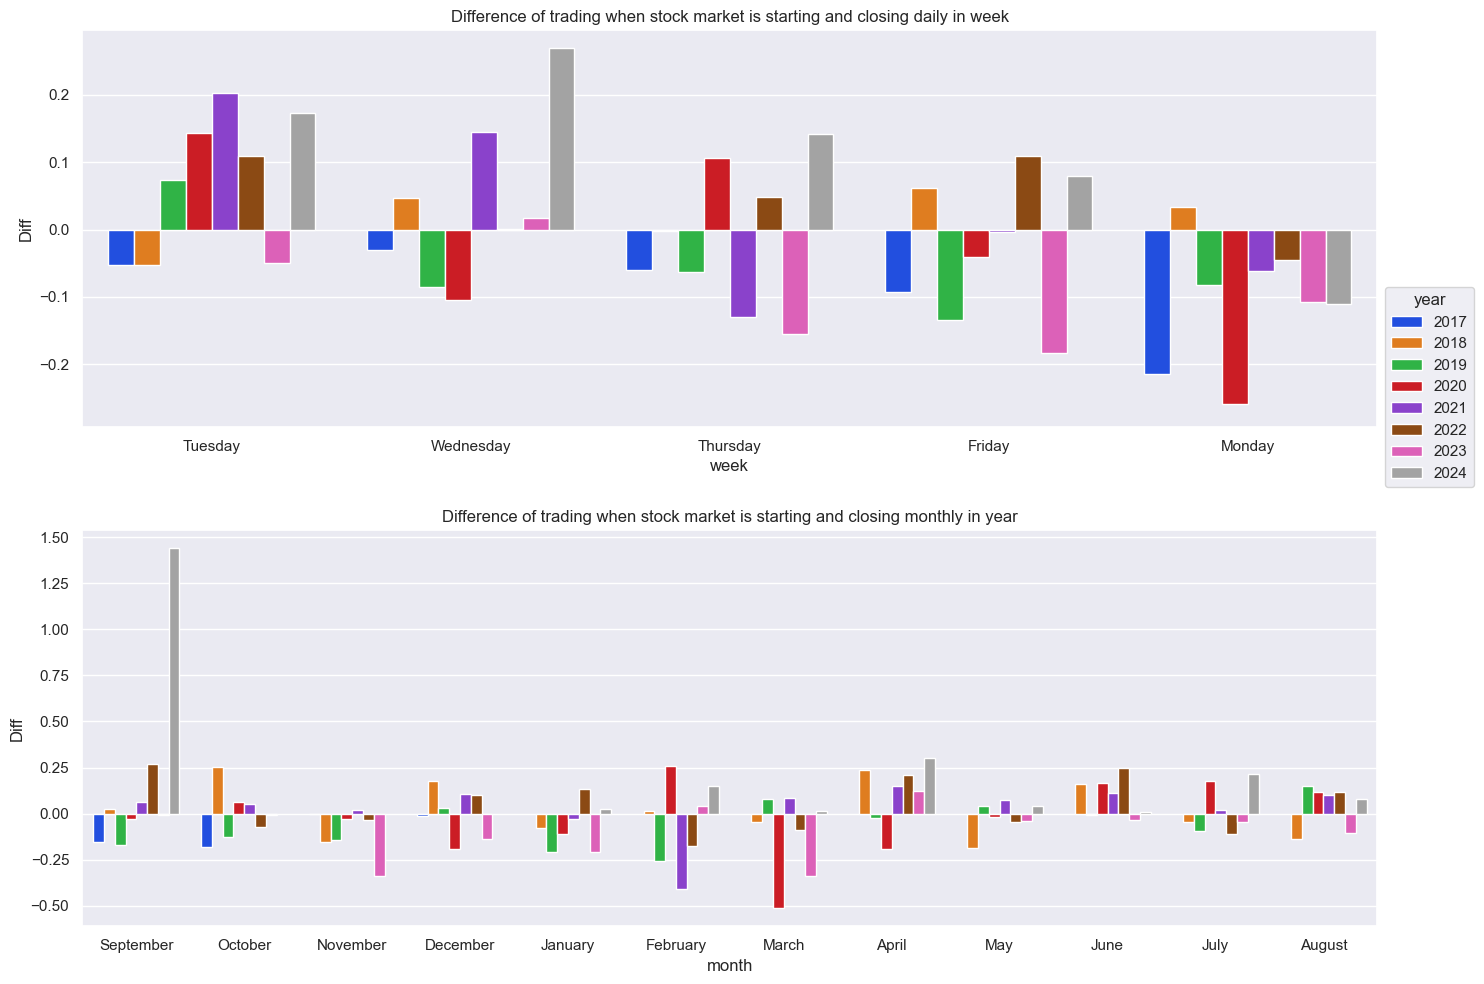

In [13]:
sns.set_theme()
# задаем координатную плоскость и соотношение графиков по высоте
fig, ax = plt.subplots(2,1, figsize=(15, 10))
# столбчатая диаграмма распределения разницы Diff по дням недели week
sns.barplot(data=stock_data, x='week', y='Diff', hue='year', palette='bright', ci=False, ax=ax[0])
ax[0].set_title('Difference of trading when stock market is starting and closing daily in week')  # название графика

# столбчатая диаграмма распределения разницы Diff по месяцам month
sns.barplot(data=stock_data, x='month', y='Diff', hue='year', palette='bright', ci=False, ax=ax[1])
ax[1].set_title('Difference of trading when stock market is starting and closing monthly in year')

# перемещаем легенду для лучшей наглядности
sns.move_legend(ax[0], "center left", bbox_to_anchor=(1, 0.1))
# удаляем лишнюю легенду
ax[1].get_legend().remove()
# выравнивание графиков
plt.tight_layout()
plt.savefig("images/Difference 'Open and Close' daily in week, monthly in year.png")
plt.show()

Рынок акций включает в себя не только долгосрочную перспективу инвестиций, но и рынок опций, когда мы зарабатываем на гипотезах роста или падения акции в течение одного дня торгов, поэтому на графиках вы можете наблюдать в какие дни в основном стоит ожидать падения стоимости акции, а в какие дни недели и даже месяцы данная акция закрывала торги с положительной разницей, но стоит понимать, что скачки цены акция могут происходить в течение дня несколько раз и рассчитывать на однозначный вариант без колебания очень рисковано, это только картина направления и большей вероятности.

На графике можно наблюдать год и месяцы с наибольшим объемом торгов, но помните, что не всегда есть корреляции между объемом торгов и изменением стоимости акции.\
Объем торгов отражает активность трейдеров, ликвидность активов и их волатильность.\
Волатильность — это параметр, который характеризует динамику изменения цены, ширину диапазона движения за фиксированный период времени. Значение параметра помогает оценить, насколько быстро изменяется цена за текущий период относительно предыдущих.

**2.2.4 Поведение скорректированной стоимости акции закрытия торгов по месяцам**\
Сгруппируем показатель скорректированной цены закрытия по интервалу с помошью функции resample (аналогична groupby), интервал выберем CBM (custom business month end frequency) - частота конца рабочего месяца.

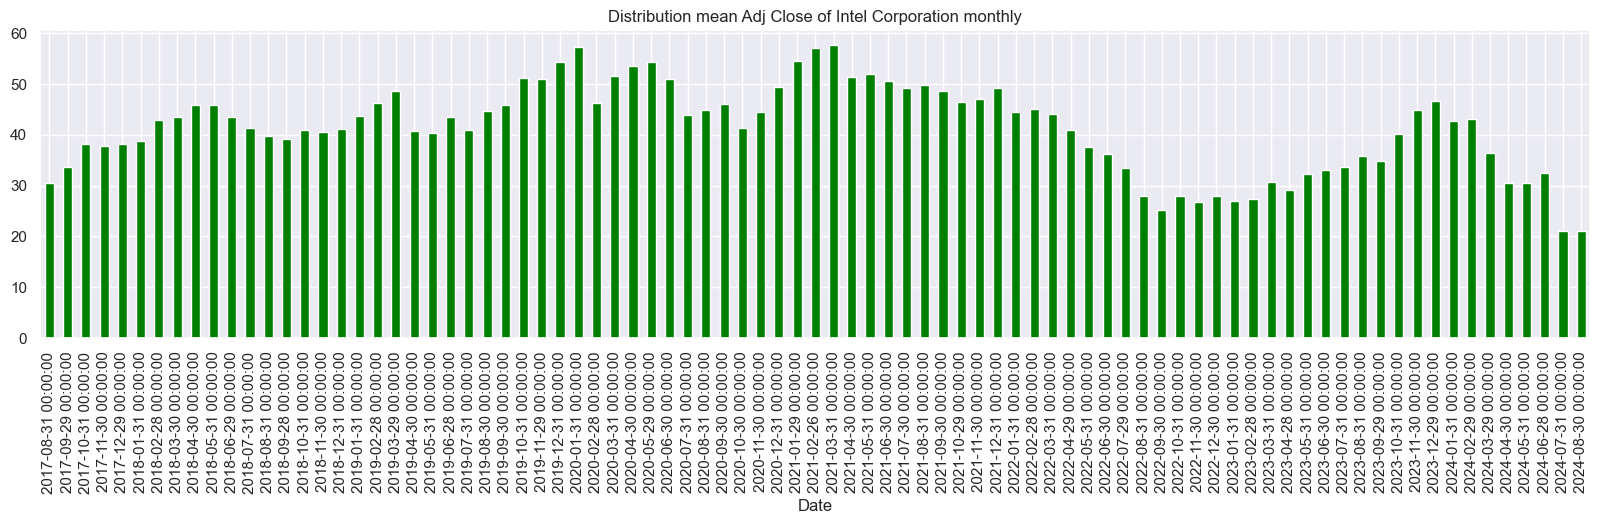

In [14]:
# группируем по интервалу и возьмем среднее значение каждого интервального периода (рабочего месяца)
# отобразим на линейном графике изменение средней скорректированной цены закрытия, сгруппированной по месяцам
stock_data['Adj Close'].resample('CBM').mean().plot(kind='bar', color='green', figsize = (20, 4))
plt.title(f'Distribution mean Adj Close of {stock} monthly')
plt.savefig('images/Distribution mean Adj Close monthly.png')   # сохранение графика
plt.show()

На таком графике неплохо бывает заметна месячная цикличность, если она имеется.

**2.2.5 Динамика стоимости акции открытия торгов и закрытия по годам**\
В цикле визуализируем движение акции в разные годы. На данных графиках мы определяем, основная тенденция изменения цены акции в течение года носит плавный характер или есть резкие колебания, что является признаком высокой волатильности. Насколько часто сменяются периоды низкой и высокой волатильности. Всегда помните, период высокой волатильности - это период риска, но профессиональные трейдеры именно в такие периоды получают наибольшую доходность от активов, если способны предсказать поведение акции.

In [15]:
# создаем список годов
years = stock_data['year'].unique().tolist()

# проходим в цикле по годам
for i in range(len(years)):
    fig = go.Figure()
    # указываем маску[i]-год, который мы отображаем на графике для признаков Open и Close, а также для индексов-дат
    fig.add_trace(go.Scatter(x = stock_data[stock_data.year==years[i]].index, y=stock_data[stock_data.year==years[i]]['Open'],
                    mode='lines', marker_color='green', name="Start trading"))
    fig.add_trace(go.Scatter(x = stock_data[stock_data.year==years[i]].index, y=stock_data[stock_data.year==years[i]]['Close'],
                    mode='lines', marker_color='blue', name="Close trading"))
    fig.update_yaxes(title=f'{years[i]}')                                                        # название для оси ординат
    fig.update_layout(
    title={'text': f"Dynamic {stock} {years[i]}",'x':0.5,'xanchor': 'center', 'yanchor': 'top'}, # параметры названия графика
    width=800, height=200,                                                                       # параметры размера графика
    autosize=False, margin=dict(t=10, b=10, l=10, r=10),
    template="plotly",
    legend=dict(yanchor="bottom",y=1, xanchor="right", x=1)                                      # расположение легенды
    )
    iplot(fig)                                                                        


#### Выводы:
* мы изучили следующие моменты: для данной акции чаще характерно положительное или отрицательное сальдо ежедневных торгов, когда лучше покупать или продавать акции, кластеризацию волатильности;
* посмотрели динамику роста акции за последний год, стоит ли вообще вкладываться в нее на долгий срок или пока заработать на опционном рынке, если имеется достаточно знаний в этой области.

Теперь мы можем перейти в анализу характеристик временного ряда, нашей целевой переменной для предсказания является цена акции закрытия торгов Close, поэтому далее мы сосредоточимся на детальном изучении всех зависимостей данного временного ряда и генерации признаков для предсказания именно таргета Close.

## 3. Кодировка категориальных признаков
Чтобы использовать созданные категориальные признаки месяца и недели в качестве дополнительного источника информации для прогноза, необходимо их преобразовать. Признак года нам больше не нужен, удалим его.

Также мы исключаем остальные показатели акции: Open, High, Low, Adj Close, Volume. 

Признаки месяца и недели относятся к категориальным номинальным и к ним применимо One-Hot-Encoding, в pandas имеется функция get_dummies, которая отвечает за однократное кодирование.

Признак разницы между ценой открытия и закрытия торгового дня Diff закодируем следующий образом: если разница отрицательна - (-1), положительна  - (+1), одинаковая стоимость - 0.

In [16]:
stock_data['Diff'] = stock_data['Diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
# посмотрим, сколько раз рынок данной акции был 'медвежий'(отрицательный) и 'бычий' (положительный)
stock_data['Diff'].value_counts()

Diff
-1    899
 1    851
 0     10
Name: count, dtype: int64

In [17]:
stock_data = stock_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'year'], axis=1)

In [18]:
stock_data = pd.get_dummies(stock_data, columns=['month', 'week'])
stock_data.head(3)

Close  Diff  month_April  month_August  month_December  \
Date                                                                     
2017-09-05  35.020000     0        False         False           False   
2017-09-06  35.759998    -1        False         False           False   
2017-09-07  35.540001     1        False         False           False   

            month_February  month_January  month_July  month_June  \
Date                                                                
2017-09-05           False          False       False       False   
2017-09-06           False          False       False       False   
2017-09-07           False          False       False       False   

            month_March  month_May  month_November  month_October  \
Date                                                                
2017-09-05        False      False           False          False   
2017-09-06        False      False           False          False   
2017-09-07        False      False           False          False   

            month_September  week_Friday  week_Monday  week_Thursday  \
Date                                                                   
2017-09-05             True        False        False          False   
2017-09-06             True        False        False          False   
2017-09-07             True        False        False           True   

            week_Tuesday  week_Wednesday  
Date                                      
2017-09-05          True           False  
2017-09-06         False            True  
2017-09-07         False           False

## 4. Анализ временного ряда акции Close
### 4.1 Декомпозиция временного ряда : тренд, сезонность (не в нашем случае), шум.
Тренд - основная тенденция изменения стоимости акции во времени, а цикличность - колебания (периоды подъема и спада) временного ряда относительно тренда (если таковые имеются).\
Функция seasonal_decompose из библиотеки statsmodels принимает на вход временной ряд и раскладывает его на трендовую, сезонную и остаточную составляющие. Так как мы знаем, что торги на бирже происходят 5 дней в неделю, то установим параметр period=5 (рабочая неделя).

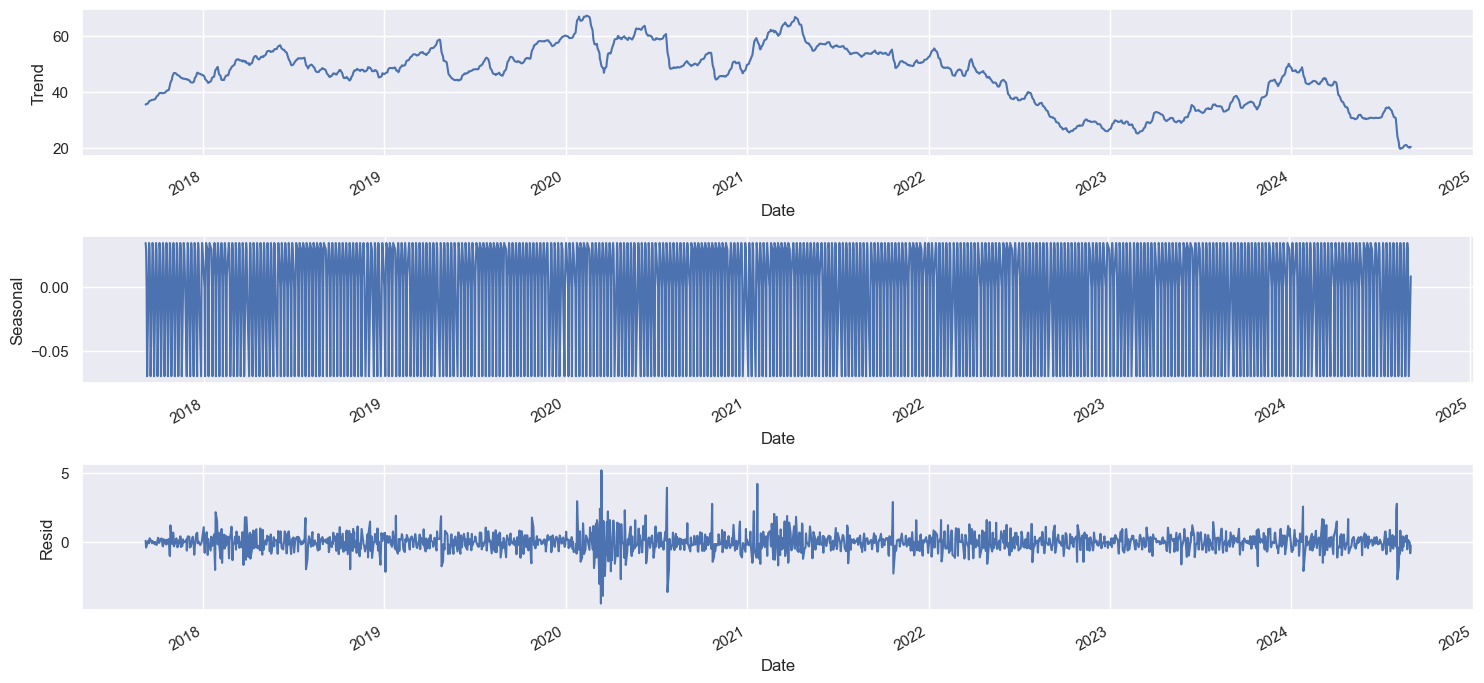

In [19]:
# декомпозируем стоимость закрытия акции
series = seasonal_decompose(stock_data.Close, period=5)
# отобразим составляющие компоненты на графиках
fig,ax = plt.subplots(3,1, figsize=(15,7))
series.trend.plot(ax=ax[0], ylabel='Trend')        # тренд
series.seasonal.plot(ax=ax[1], ylabel='Seasonal')  # сезонность
series.resid.plot(ax=ax[2], ylabel='Resid')        # остатки(шум)
plt.tight_layout()
plt.savefig('images/Trend, Seasonal, Resid.png');

Естественно, акции компании не имеют такую характеристику временного ряда как сезонность, прежде всего мы смотрим на тренд.

### 4.2 Изучение зависимостей (последовательностей) во временном ряду: автокорреляция, частичная корреляция, стационарность.
Создаем функцию, которая примет на вход наш временной ряд и с помошью специальных инструментов библиотеки statsmodels отобразит статистическую взаимосвязь между последовательностями значений ряда: корреграмма plot_acf (график автокорреляция), частичная автокорреляция plot_pac, QQ-график и распределение остатков.
1) Автокорреляция так и переводится - это корряция временного ряда с самим с собой: насколько значение во временном ряду похоже на предыдущее. Она помогает выявлять тенденции и оценивать влиянее ранее наблюдаемых значений (лагов) на текущее наблюдение. Значения на коррелограмме будут близки к нулю, если данные ряда не зависят от себя в прошлом. Если максимальное значение на коррелограмме находится в лаге 1, то ряд содержит только тренд. Если максимальное значение выражено ненулевым или первым лагом (например, 5), то временной ряд содержит циклическую компоненту с периодом 5. Лаги отображают инерцию зависимости, то есть если все лаги выше доверительного интервала (по умолчанию равен 95%) снижаются постепенно, то более дальные наблюдения оказывают меньший эффект на текущее значение.
2) Частичная автокорреляция описывает только прямую связь между текущим наблюдением и наблюдениями на предыдущем отрезке времени с удалением взаимосвязей между промежуточными наблюдениями. Частичная автокорреляция даёт более «чистую» картину периодических зависимостей, так как исключается влияние автокорреляций с меньшими лагами.
3) QQ график представляет линию главного тренда вокруг прямой идеального нормального распределения для наших данных.\
Если оба конца квантильного графика находятся выше прямой главного тренда, то скорее всего это распределение скошено вправо.\
Если оба конца квантильного графика находится ниже прямой главного тренда, то скорее всего это распределение скошено влево.\
Если точки на графике Q-Q Plot стелятся вдоль прямой, то наши данные неплохо соответствуют теоретическим квантилям, отложенным по горизонтальной оси.\
Равномерное распределение - это S-образная кривая, стелющаяся вдоль линии тренда, бимодальное распределение - это S-образная кривая, пересекающая линию тренда, t-распределение - это зеркально отраженная S-образная кривая.
4) Гистограмма распределения.


In [20]:
# функция для графического отображения зависимости последовательностей временного ряда
# агрументы: временной ряд X, координатная плостость, название графика и лаги(количество предыдущих наблюдений)
def tsdisplay(X, figsize = (20, 15), title = " ", lags = 40):
    fig = plt.figure(figsize = figsize)
    
    # линейный график исходных данных временного ряда
    X.plot(ax = fig.add_subplot(311), title = "True Time Series", legend = False)
    
    # коррелограмма, исключаем нулевой лаг, который отражает корреляцию с самим собой
    sm.graphics.tsaplots.plot_acf(X, lags = lags, zero = False, ax = fig.add_subplot(323))  
    plt.xticks(np.arange(1,  lags + 1, 1.0)) 
    
    # график частичной автокорреляции
    sm.graphics.tsaplots.plot_pacf(X, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0)) 
    
    # график квантиль-квантиль
    sm.graphics.gofplots.qqplot(X, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    
    # гистограмма распределения остатков
    fig.add_subplot(326).hist(X, bins = 40)
    plt.title("Histogram")
        
    plt.tight_layout()          # выравнивание графиков
    plt.show()

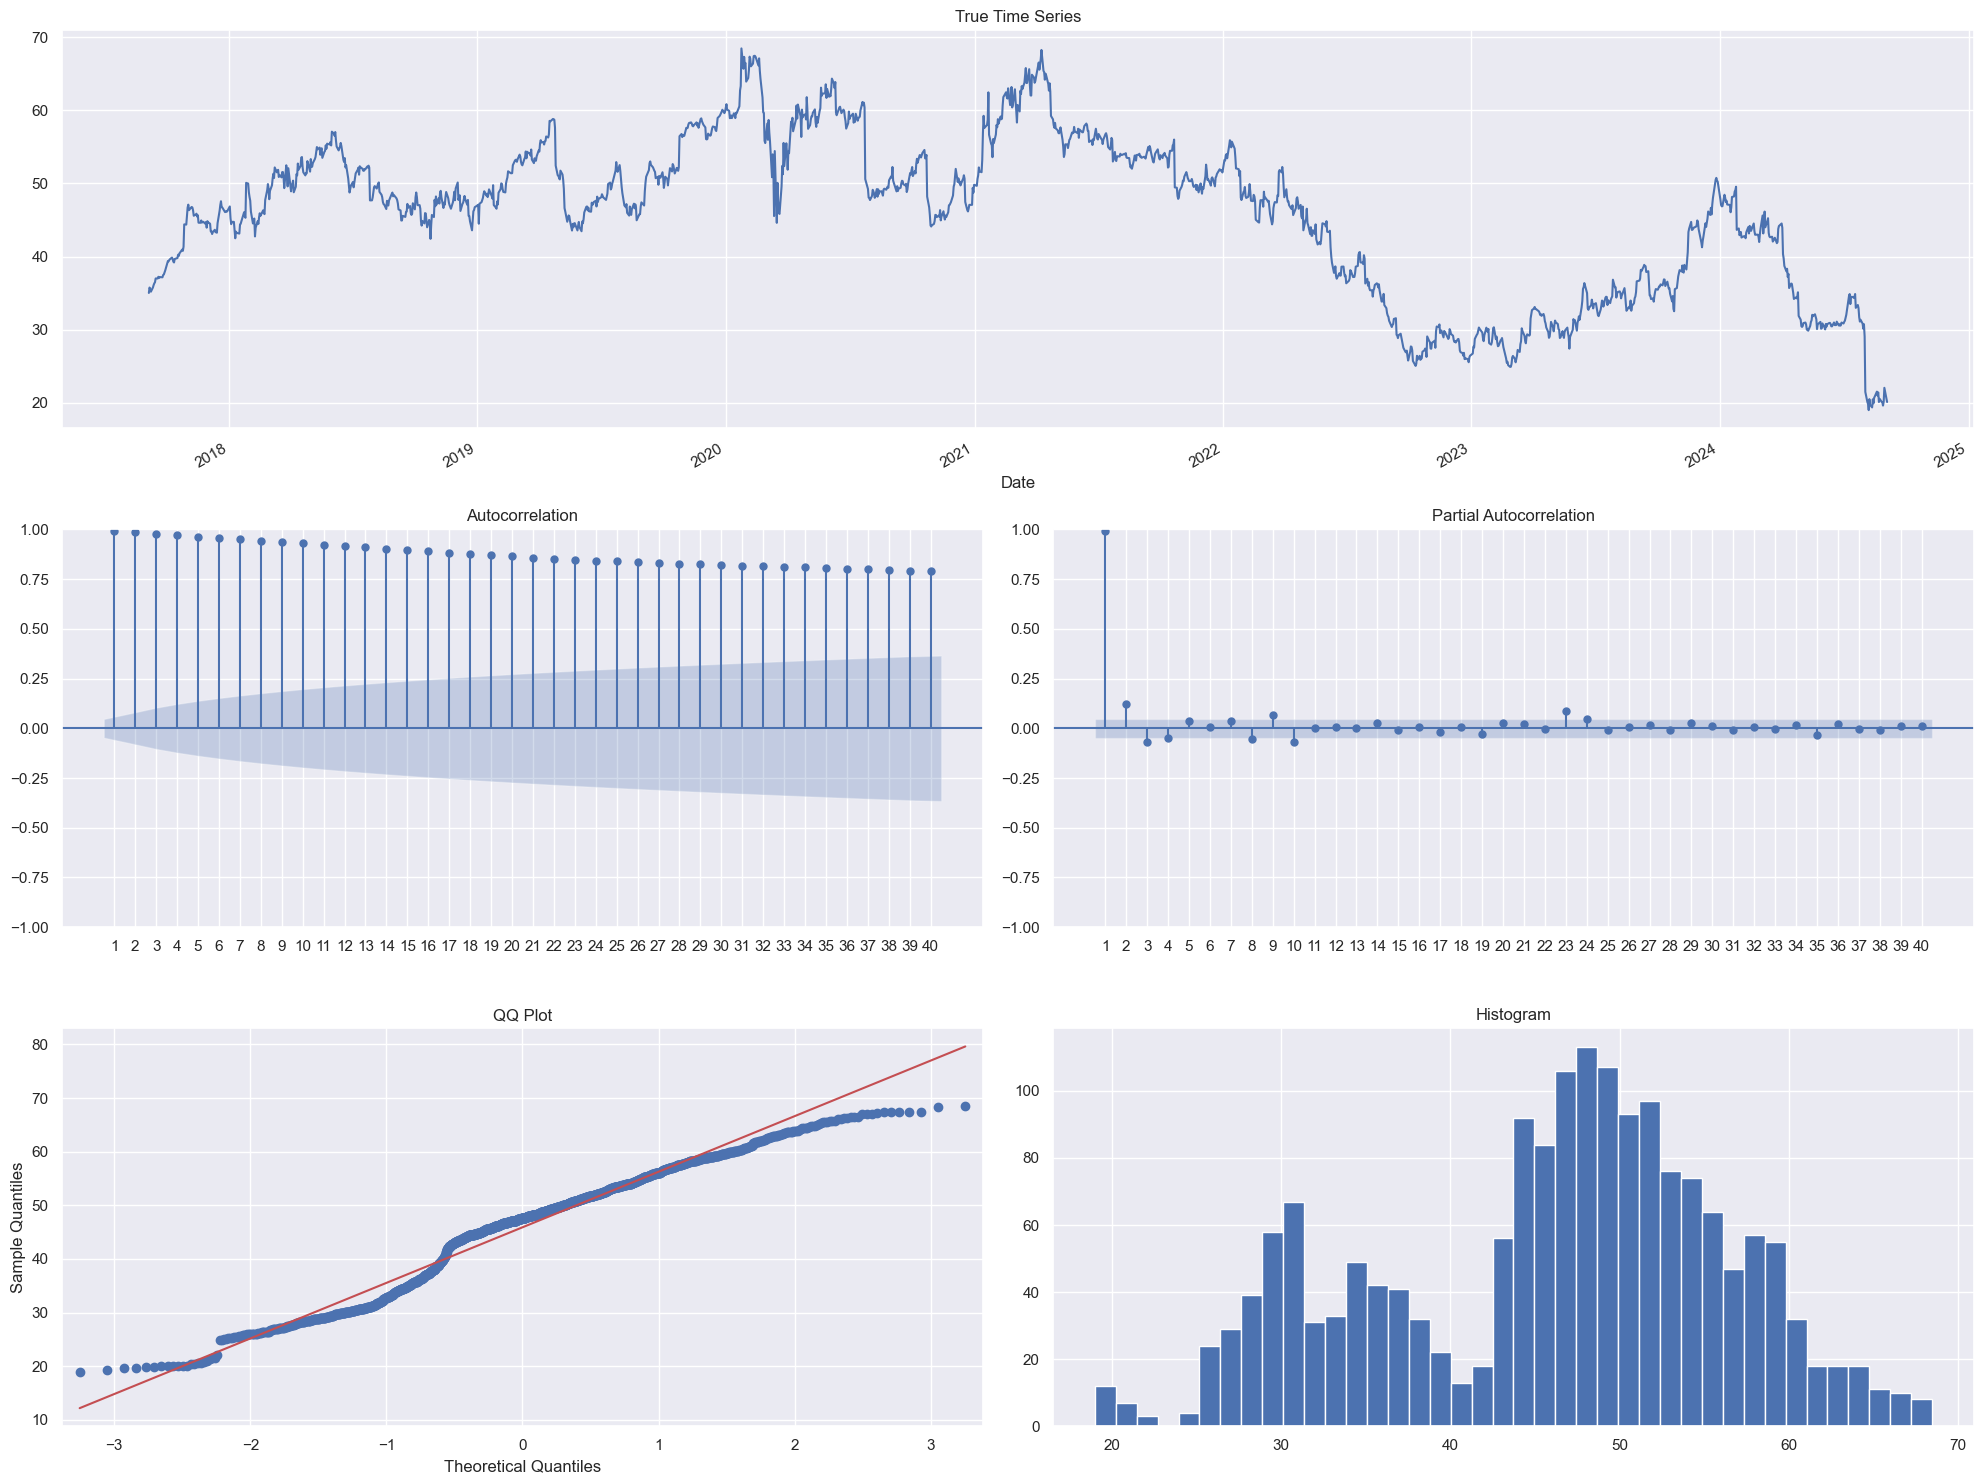

In [21]:
# применим функцию
tsdisplay(stock_data.Close)

Однозначно видим фаворита авторегрессии - лаг номер 1 (по графику частичной автокорреляции), то есть самое сильное влияние на текущее значение имеет последнее предыдущее наблюдение.

Тренд выражен не четко, резкие колебания.

По коррелограмме мы видим, как медленно снижается корреляция с прошлыми значениями, даже 40 лаг оказывает влияние на текущее значение.

### 4.3 Стационарность временного ряда
Очень важным для прогнозирования является наличие стационарности у временного ряда, когда математическое ожидание, дисперсия и совместное распределение вероятности значений ряда не меняются при сдвиге во времени в отличие от изменения значений со временем.
Лишь стационарный процесс предсказуем. У стационарного ряда отсутствует тренд и сезонность.

Проведем тест на стационарность, применив тест Дики-Фуллера adfuller() из той же библиотеки statsmodels.
* Нулевая гипотеза $H_0$: временной ряд нестационарен, т.е. имеет некоторый тренд и сезонную компоненту. Значение статистики $p > \alpha$ - уровня значимости.
* Альтернатиная гипотеза $H_1$: временной ряд стационарен, не имеет тренда и сезонной компоненты, данные скорее случайны. Значение статистики $p < \alpha$ - уровня значимости.

Если тест подтвердит нестационарность, то применим дифференцирование ряда - разность между двумя соседними наблюдениями. Дифференцирование мы будем повторять до тех пор пока ряд не приобретет стационарность. Весь этот процесс обернем в функцию.

In [22]:
# функция тестирования временного ряда на стационарность и дифференцирования его в случае нестационарности
def get_stationary(Series):
    # создаем копию временного ряда, которую будем тестировать
    data = Series.copy()
    differenced = adfuller(data)                    # функция тестирования
    print('adf: ', differenced[0])                  # значение критерия теста
    print('p-value: ', differenced[1])              # значение p-value
    print('Critical values: ', differenced[4])      # пороговые значения доверительного интервала (0.01, 0.05, 0.1)
    count = 0                                       # переменная для подсчета порядка дифференцирования
    while differenced[0] > differenced[4]['5%']:
        print('Ряд нестационарен')
        data = data.diff().dropna()                   # дифференцируем с помощью функции diff() 
        differenced = adfuller(data)                  # вновь тестируем
        count += 1
    else:
        print('Ряд стационарен')
        print('-----------------------')
    return count, data

In [23]:
# применим функцию преобразования ряда к стационарному
count, stock_data['Close_diff'] = get_stationary(stock_data['Close'])
# выведем порядок дифференцирования
print('Порядок интегрированного ряда: ',count)

adf:  -1.5454071048921962
p-value:  0.5109415841562416
Critical values:  {'1%': -3.4340922388213175, '5%': -2.863192990001633, '10%': -2.5676500029387754}
Ряд нестационарен
Ряд стационарен
-----------------------
Порядок интегрированного ряда:  1


Отобразим на графике интегрированный временной ряд порядка переменной count и исходный, чтобы увидеть, что ряд действительно теперь стационарен

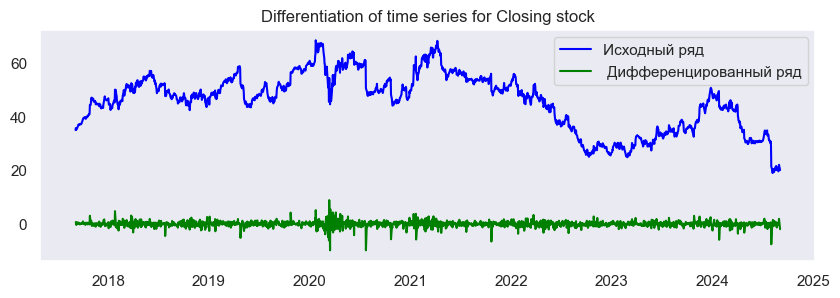

In [24]:
plt.figure(figsize=(10,3))
plt.plot(stock_data['Close'], label='Исходный ряд', color='blue')
plt.plot(stock_data['Close_diff'], label=' Дифференцированный ряд', color='green')
plt.title('Differentiation of time series for Closing stock')
plt.grid() 
plt.legend()
plt.show()

Проверим как изменился временной ряд, автокорреляция и частичная автокорреляция после дифференцирования.

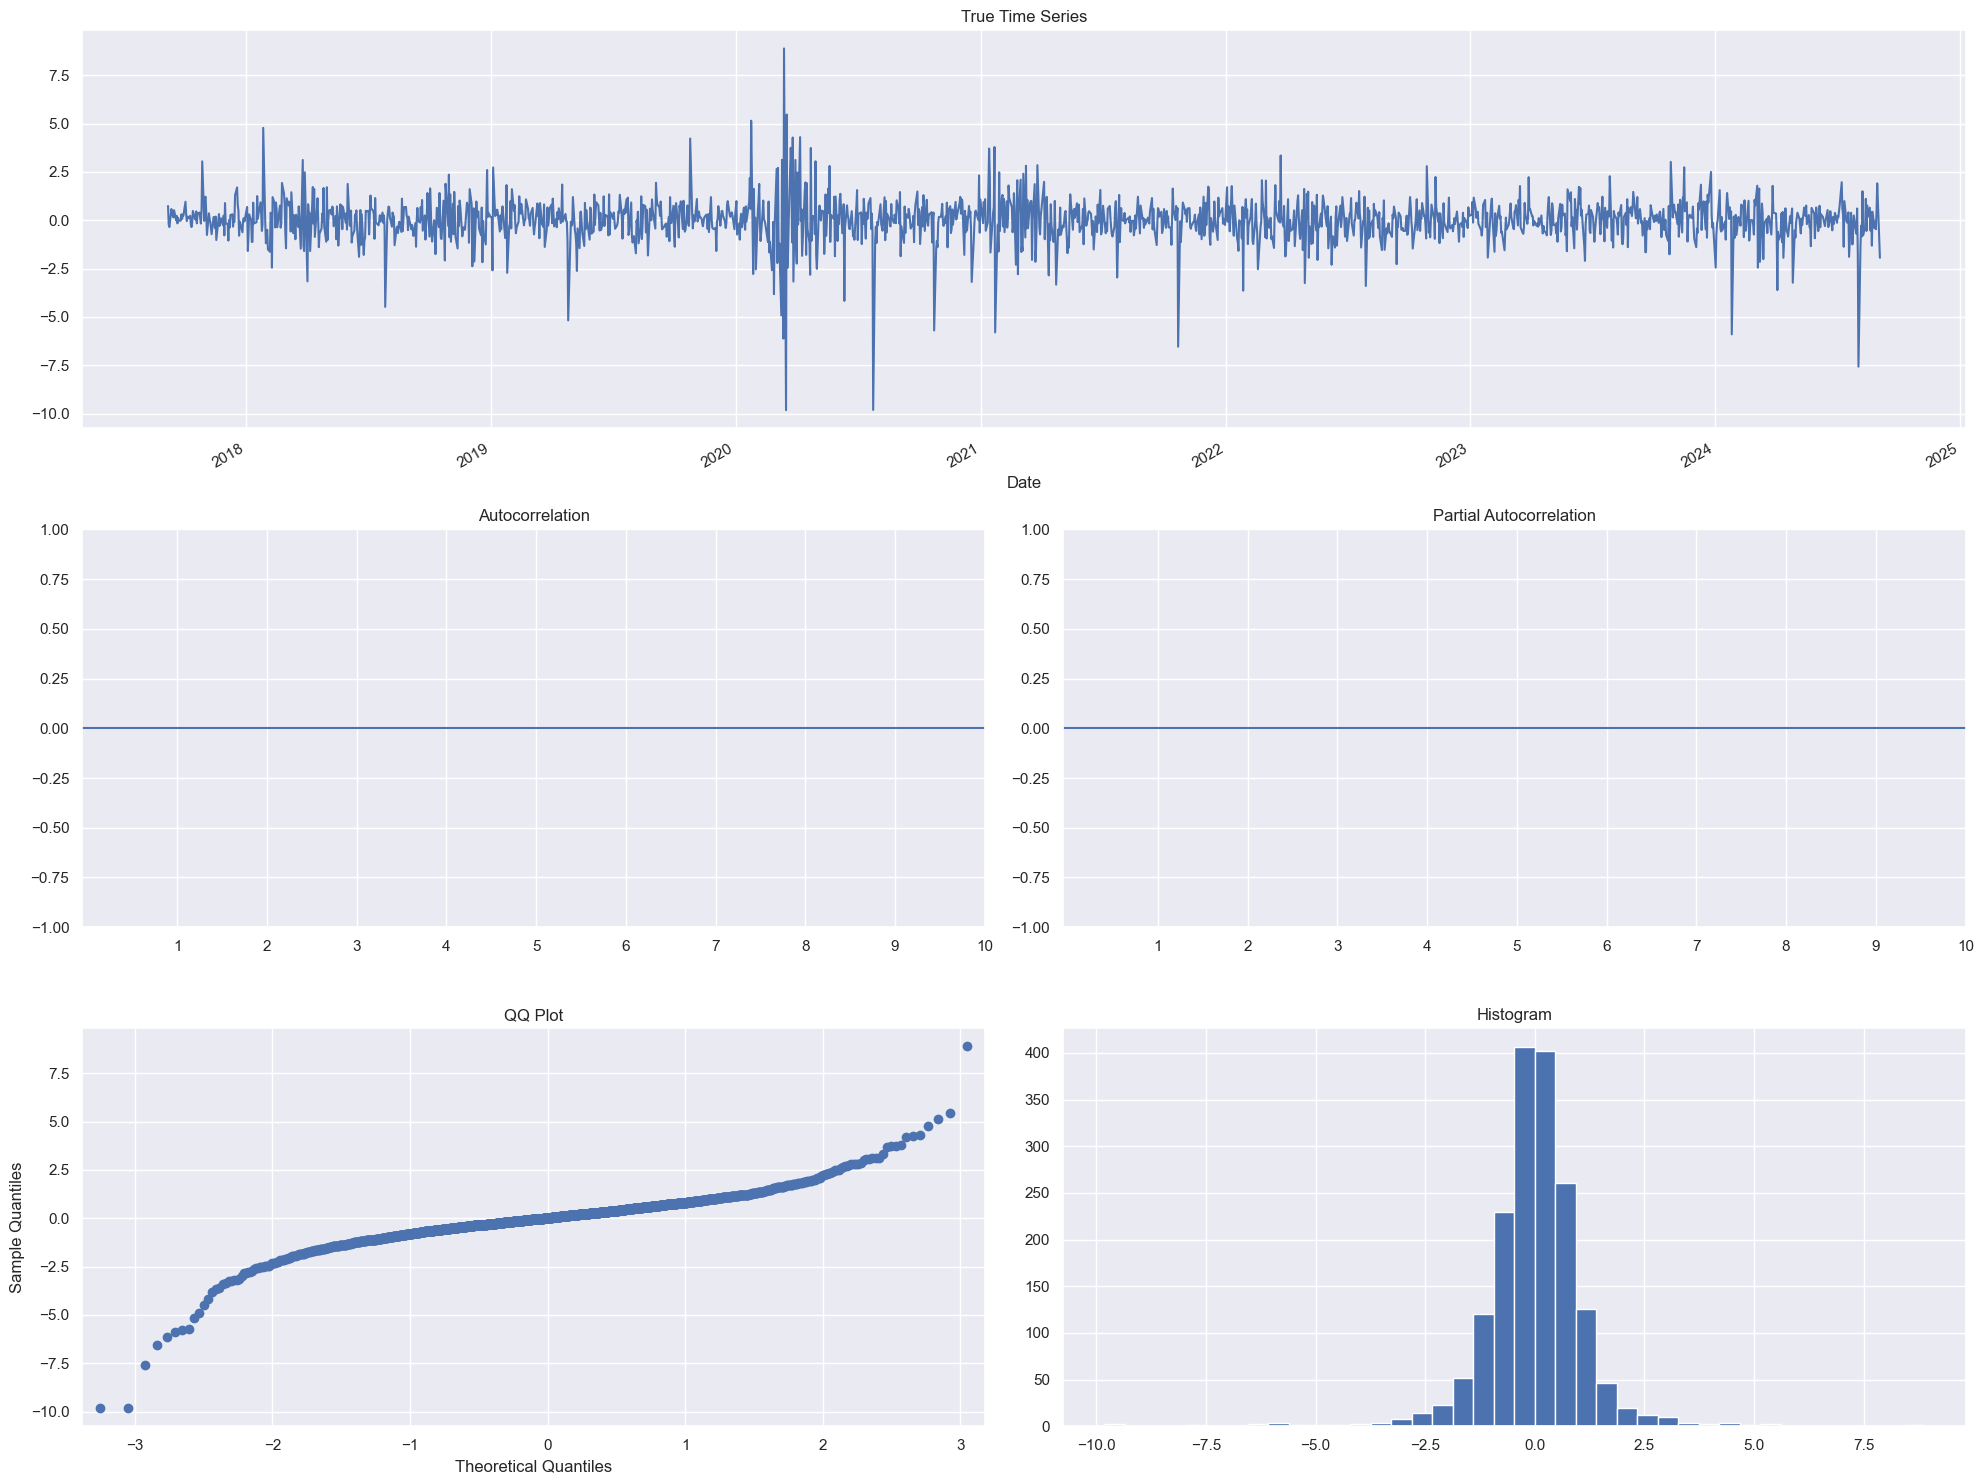

In [25]:
tsdisplay(stock_data['Close_diff'], lags=10)

После приведения ряда к стационарности, мы начинаем подбирать порядок для авторегрессионых моделей по графику частичной автокорреляции, мы смотрим номер последнего временного лага, сильно отличного от нулевого, который замеряет корреляцию между данными ряда и некоторым запаздываем, он и определяет порядок в AR-моделях. Также необходимо подобрать значение MA-скользящего среднего по коррелограмме по тому же принципу наибольшего.\
Таких вариантов бывает несколько и обычно мы перебираем оптимальный с помощью перебора. Но мы обратимся к библиотека pmdarima, которая обладает функционалом автоподбора.

Давайте до того, как мы перейдем к моделированию, сгенерируем новые признаки, а точнее рассчитаем несколько индексов и скользящих средних, которые нам понадобятся для построения алгоритма градиентного бустинга с помощью XGBoost, данная модель обычно не занимается прогнозированием временных рядов, но ее сильная сторона - точность предсказания, посмотрим как она способна через сгенерированные признаки увидеть зависимости в нашем ряду Close.

## 5. Feature engineering для целевого признака Close (подготовка к моделированию).

### 5.1 Создание нескольких вариантов простых прогнозирований в качестве признаков.
Построим модели MA (moving average) скользящего среднего с помощью метода rolling(), который принимает в качестве параметра размер окна (сумма нескольких последовательных наблюдений временного ряда), а далее применим агрегирующую функцию усреднения (деления на количество этих наблюдений). Особо большой период сглаживания не рекомендуется брать, это самая простая модель и больше подходит для краткосрочного прогноза.
И дополнительно создадим пару признаков экспоненциального сглаживания, чаще всего для фондового рынка минимальную экспоненциальную скользящую берут размером 9 и 14, в pandas для этого предусмотрена функция dataframe.ewm().

In [26]:
# для прогнозирования возьмем следующие значения окна для сглаживания: 
# 5 (рабочая неделя), 9 (оптимальное сглаживание, применяемое на фондовых рынках),
# 15 (три рабочих недели), 30 (1,5 месяца рабочих дней)
stock_data['EMA_9'] = stock_data['Close'].ewm(9).mean()           # экспоненциальная скользящая средняя
stock_data['EMA_14'] = stock_data['Close'].ewm(14).mean()
stock_data['MA_5'] = stock_data['Close'].rolling(5).mean()        # простая скользящая средняя
stock_data['MA_9'] = stock_data['Close'].rolling(9).mean()
stock_data['MA_15'] = stock_data['Close'].rolling(15).mean()
stock_data['MA_30'] = stock_data['Close'].rolling(30).mean()

# отобразим на графике
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.EMA_14, name='EMA 14'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.MA_5, name='MA 5'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.MA_9, name='MA 9'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.MA_15, name='MA 15'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.MA_30, name='MA 30'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.Close, name='Close'))
fig.update_layout(
    title={'text': f"Simple moving average Close",'x':0.5,'xanchor': 'center', 'yanchor': 'top'}, 
    width=1000, height=400,
    autosize=False, margin=dict(t=30, b=60, l=30, r=10),
    template="plotly",
    legend=dict(yanchor="bottom", y=-0.2, orientation='h', xanchor="right", x=0.9)
    )
iplot(fig)

### 5.2 Индекс относительной силы Relative Strength (RSI) Index
Индикатор, определяющий силу тренда и вероятность его смены.

Формула расчета RSI:
$$RSI = 100 — \frac{100}{(1 + \frac{Up_{eman}}{Down_{eman}})}$$
где $Up_{eman}$ — средний рост цены за период n, сглаженный экспоненциально,
$Down_{eman}$ — среднее снижение цены за период n, сглаженное экспоненциально.
Чаще всего длительность периода усреднения принято брать 14 торговых (рабочих) дней.

Благодаря экспоненциальному методу усреднения и формуле расчета индикатора ценовые движения проецируются на график со шкалой от 0 до 100, наглядно показывая ценность каждого ценового изменения.
  

In [27]:
# функция создания индекса приминает временной ряд и число - период для сглаженного усреднения
def relative_strength_idx(data, n=14):
    close = data['Close']
    differenced = close.diff()           # дифференцируем, приводим к стационарности
    differenced = differenced[1:]        # отсекаем первое значение, так как оно будет NaN
    close_up = differenced.copy()      
    close_down = differenced.copy()
    # разделяем, когда цена росла и когда падала
    close_up[close_up < 0] = 0           # обнуляем отрицательные значения
    close_down[close_down > 0] = 0       # обнуляем положительные значения
    rolling_up = close_up.rolling(n).mean()            # скользящее среднее для цены роста
    rolling_down = close_down.abs().rolling(n).mean()  # скользящее среднее для цены снижения
    rs = rolling_up / rolling_down                     # применяем формулу расчета
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
# применим функцию вычисления индекса RSI
stock_data['RSI'] = relative_strength_idx(stock_data).fillna(0)

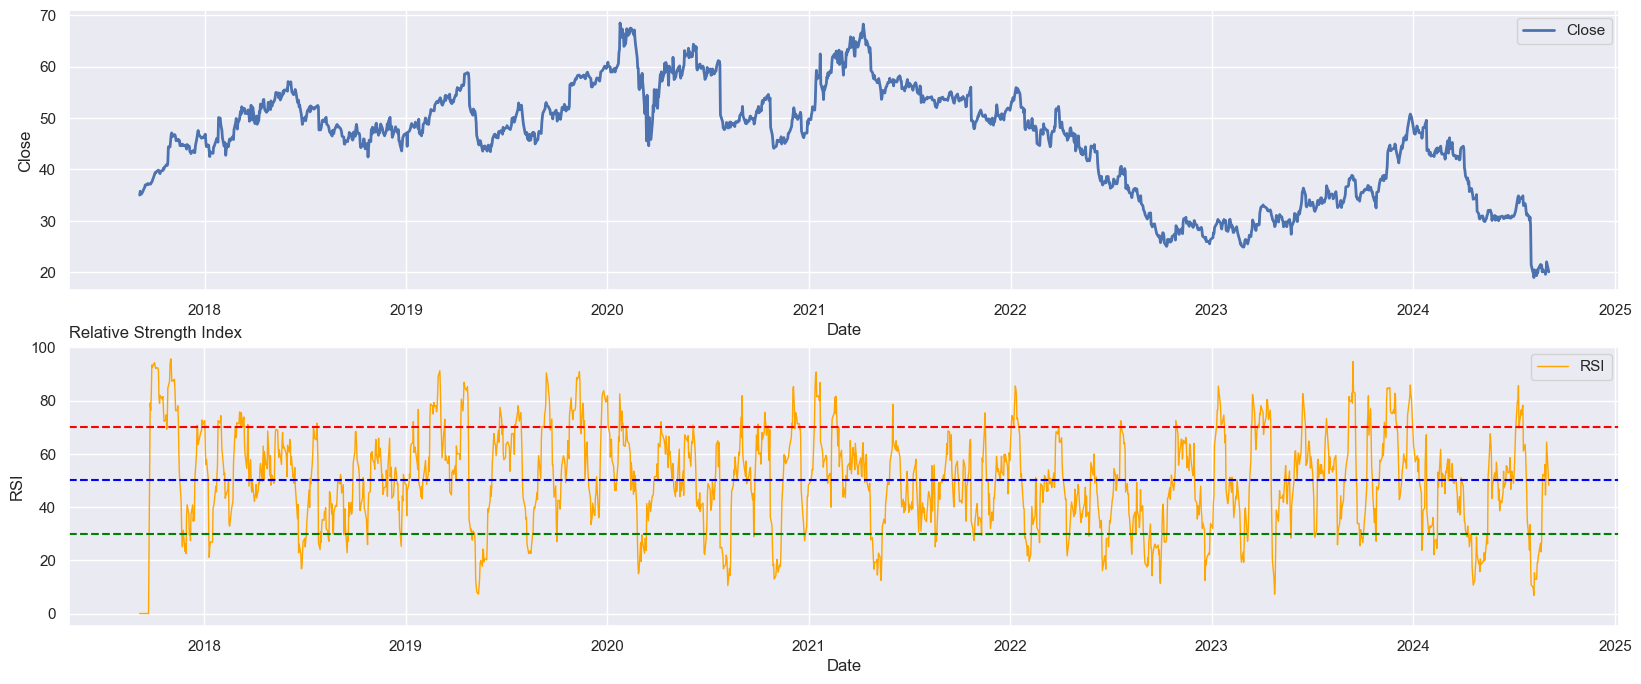

In [28]:
fig, ax = plt.subplots(2,1, figsize=(20,8))
# линейный график исходной стоимости
sns.lineplot(stock_data['Close'], linewidth=2, label='Close', ax=ax[0])
# линейный график индекса
sns.lineplot(stock_data['RSI'], color='orange', linewidth=1, label='RSI', ax=ax[1])

# отобразим линии перехода тренда
plt.axhline(30, linestyle='--', linewidth=1.5, color='green')
plt.axhline(50, linestyle='--', linewidth=1.5, color='blue')
plt.axhline(70, linestyle='--', linewidth=1.5, color='red')

plt.title('Relative Strength Index', loc='left')
plt.tight_layout
plt.savefig('images/RSI index.png')
plt.show()

По колебаниям индекса мы определяем, когда купить (пересечение ниже зеленой линии), а когда продать актив (пересечение выше красной линии). Пересечение идексом уровня 50 означает, что преобладающим становится усредненное движение либо вверх, либо вниз. Такое пересечение может свидетельствовать о начале тренда. 

Не являесь экспертом, а только понимая важность данного индекса для трейдинга, предлагаю вам для ознакомления статью [прочитать](https://www.investopedia.com/terms/r/rsi.asp).

### 5.3 Индикатор MACD Moving Average Convergence/Divergence для оценки и прогнозирования колебаний цен на фондовой и валютной биржах.
Давайте применим еще один важный инструмент, основанный на схождении/расхождении скользящих средних. Что он определяет:
- направление основного тренда;
- моменты смены тренда и/или начала коррекционного движения;
- волатильность акции в текущий период времени. 
Данный индикатор отсеивает незначительные краткосрочные движения цены и позволяет купить или продать актив на первых этапах нового тренда.

Согласно [Wikipedia](https://en.wikipedia.org/wiki/MACD) для расчёта линейного MACD из экспоненциальной скользящей средней с меньшим периодом вычитается экспоненциальная скользящая средняя с большим периодом. Также полученный результат сглаживают при помощи экспоненциальной скользящей средней (EМА), чтобы устранить случайные колебания.
$$MACD = ЕМА_s(P) − EMA_l(P)$$
Сигнальная линия MACD:
$$Signal = EМА_a(ЕМА_s(P) − EMA_l(P))$$
где:
* $EMA_s(P)$ — экспоненциальная скользящая средняя с коротким периодом от цены.
* $ЕМА_l(P)$ — экспоненциальная скользящая средняя с длинным периодом от цены.
* $EМА_a(P)$ — сглаживающая скользящая средняя с коротким периодом от разницы двух остальных скользящих.
* $P$ — цена, обычно берётся цена закрытия периода Close, как в нашем случае, но возможны и другие варианты.

По умолчанию часто используют следующие настройки MACD:
* $ЕМА_s$ — (короткая) с периодом 12 дней.
* $ЕМА_l$ — (длинная) с периодом 26 дней.
* $EМА_a$ — (сглаживающая разницу) с периодом 9 значений.

In [29]:
# рассчитываем экспоненциальные скользящие средние с периодами 12 и 26
EMA_12 = pd.Series(stock_data['Close'].ewm(span=12, min_periods=12).mean())   
EMA_26 = pd.Series(stock_data['Close'].ewm(span=26, min_periods=26).mean())
# считаем разницу
stock_data['MACD'] = pd.Series(EMA_12 - EMA_26)
# считает скользящую среднюю от разницы
stock_data['MACD_signal'] = pd.Series(stock_data.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1, subplot_titles=('Exponentional Moving Average',  'MACD'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=stock_data.index, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=stock_data.index, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['MACD_signal'], name='Signal line'), row=2, col=1)
fig.update_layout(
    width=1000, height=500,
    autosize=False, margin=dict(t=30, b=60, l=30, r=10),
    template="plotly",
    legend=dict(yanchor="bottom", y=-0.2, orientation='h', xanchor="right", x=0.9)
    )
iplot(fig)

В отношении тренда индикатор MACD показывает направление и силу: если основная линия находится в положительной области, тренд считают восходящим; при расположении основной линии ниже нулевого уровня говорят о нисходящем тренде, пересечение основной линией уровня нуля считают моментом смены тренда.

Очистим подготовленный к моделированию датасет от всех пустых значений, сформированных в процессе 'сглаживаний'.

In [30]:
stock_data.dropna(axis=0, inplace=True)
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1727 entries, 2017-10-20 to 2024-09-03
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close            1727 non-null   float64
 1   Diff             1727 non-null   int64  
 2   month_April      1727 non-null   bool   
 3   month_August     1727 non-null   bool   
 4   month_December   1727 non-null   bool   
 5   month_February   1727 non-null   bool   
 6   month_January    1727 non-null   bool   
 7   month_July       1727 non-null   bool   
 8   month_June       1727 non-null   bool   
 9   month_March      1727 non-null   bool   
 10  month_May        1727 non-null   bool   
 11  month_November   1727 non-null   bool   
 12  month_October    1727 non-null   bool   
 13  month_September  1727 non-null   bool   
 14  week_Friday      1727 non-null   bool   
 15  week_Monday      1727 non-null   bool   
 16  week_Thursday    1727 non-null   bool   
 

## 6. Моделирование
### 6.1 ARIMA Autoregressive Integrated Moving Average - модель авторегрессионной интегрированной скользящей средней.
ARIMA применяется, когда ряд не стационарен, имеется тренд и задается параметр d, отвечающий за порядок интегрированного (дифференцированного) ряда.\
AR (авторегрессия) - >>> использует прошлые значения для прогнозирования будущего (параметр p).\
I  - >>> дифференцирование наблюдений, приведение данных к стационарным (параметр d).\
MA (Скользящее среднее) >>> использует прошлые значения ошибок в данном ряду для прогнозирования будущего (параметр q).

Прежде всего мы раздедим данные на обучающую и тестовую выборку в соотношение 80/20. Помним, что для временного ряда подходит только последовательное упорядоченное сплитование.

Дополним модель экзогенными признаками месяца и дня недели, а также показатель разницы между началом и завершением торгов. Экзогенные признаки необходимо указать как при обучении, так и при прогнозировании.

In [31]:
# дополнительный набор экзогенных признаков: month, week, Diff
exog_df = stock_data.drop(['Close', 'Close_diff', 'EMA_9', 'EMA_14', 'MA_5', 'MA_9', 'MA_15', 
                           'MA_30', 'RSI', 'MACD', 'MACD_signal'], axis=1)

In [32]:
# определяем 80% на обучающую выборку и 20 на тестовую, индекс - длина 80% данных временного ряда
index = int(len(stock_data[['Close']]) * 0.8) 
train = stock_data[['Close']][0:index]      # обучающий набор от первого значения до найденного индекса
exog_train = exog_df[0:index]               

test = stock_data[['Close']][index:]        # тестовый набор начинается от значения отсчитанного индекса
exog_test = exog_df[index:]
train.shape, test.shape

((1381, 1), (346, 1))

Для построения модели ARIMA используем автоподбор наилучших гиперпараметров с помощью **pmdarima**


In [33]:
arima_model = pm.auto_arima(
    y=train,
    exog=exog_train,
    start_p=1, d=count, start_q=1,   # в параметре d указываем порядок дифференцирования, который мы вычислили ранее
    max_p=20, max_q=20,              # задаем максимальные значения для порядка авторегрессии и скользящего среднего
    test="adf",                      
    error_action="ignore", 
    suppress_warnings=True,
    trace=True,                      # выводить всю информацию об итерациях
    seasonal=False,                  # сезонная составляющая отсутстует
    maxiter=100
)
arima_model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4312.260, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4356.911, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4312.698, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4318.804, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4354.950, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4309.026, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4307.246, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4308.857, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4301.124, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4288.774, Time=1.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4309.666, Time=0.75 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4313.654, Time=0.88 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4301.229, Time=2.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1381
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -2137.036
Date:                Wed, 04 Sep 2024   AIC                           4286.073
Time:                        16:50:02   BIC                           4317.452
Sample:                             0   HQIC                          4297.811
                               - 1381                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8813      0.047    -39.840      0.000      -1.974      -1.789
ar.L2         -1.0958      0.064    -17.255      0.000      -1.220      -0.971
ar.L3         -0.0933      0.024     -3.920      0.000      -0.140      -0.047
ma.L1          1.7269      0.043     40.090      0.000       1.642       1.811
ma.L2          0.8481      0.040     21.048      0.000       0.769       0.927
sigma2         1.2957      0.021     60.739      0.000       1.254       1.338
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6302.65
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.88
Prob(H) (two-sided):                  0.10   Kurtosis:                        13.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# сделаем предсказание с помошью модели ARIMA и вернем доверительный интервал
pred, ci_pred = arima_model.predict(n_periods=test.shape[0], X=exog_test, return_conf_int=True, alpha=0.05)
# вычислим среднюю абсолютную ошибку в процентах между истинными и предсказанными значениями стоимости акции
print('Абсолютная средняя ошибка в процентах: {}%'.format(round(mean_absolute_percentage_error(test, pred)*100,2)))
# запишем предсказанные значения в dataframe, включая значения доверительного интервала
forecast = pd.DataFrame({'predictions': pred, 'conf_int_lower': ci_pred[:,0], 'conf_int_upper': ci_pred[:,1]})
# установим индексы-даты
forecast.index = test.index
# объединяем предсказания и истинные значения
forecast = pd.concat([forecast, test], axis=1)
# выведем последние 10 строк
forecast.tail(10)

Абсолютная средняя ошибка в процентах: 16.25%


predictions  conf_int_lower  conf_int_upper      Close
Date                                                              
2024-08-20     31.88785       -4.097784       67.873485  20.990000
2024-08-21     31.88785       -4.151096       67.926796  21.410000
2024-08-22     31.88785       -4.204328       67.980028  20.100000
2024-08-23     31.88785       -4.257482       68.033183  20.540001
2024-08-26     31.88785       -4.310558       68.086259  20.129999
2024-08-27     31.88785       -4.363557       68.139257  20.070000
2024-08-28     31.88785       -4.416478       68.192178  19.610001
2024-08-29     31.88785       -4.469321       68.245022  20.129999
2024-08-30     31.88785       -4.522089       68.297789  22.040001
2024-09-03     31.88785       -4.574780       68.350480  20.100000

К сожалению, ARIMA модель слишком плохо уловила зависимости временного ряда цены акции, ошибка высока.

Визуализируем прогноз модели ARIMA.

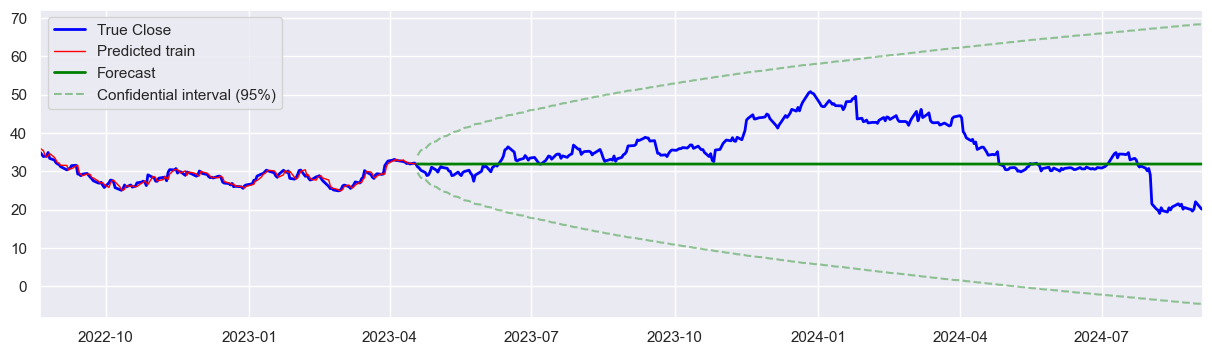

In [35]:
left = datetime(2022, 8, 20)
right = datetime.now() - timedelta(days=1)
fig = plt.figure(figsize=(15,4))
plt.plot(stock_data.Close, color='blue', label='True Close', linewidth=2)                # истинные значения
plt.plot(arima_model.fittedvalues(), color='red', label='Predicted train', linewidth=1)  # предсказанные по обучающей выборке
plt.plot(forecast.predictions, color='green', label='Forecast', linewidth=2)             # предсказание по тестовому набору
plt.plot(forecast['conf_int_lower'], color='green', linestyle='--', alpha=0.4, label='Confidential interval (95%)')
plt.plot(forecast['conf_int_upper'], color='green', linestyle='--', alpha=0.4)
plt.gca().set_xbound(left, right) # урежем отображение на оси абсцисс для наглядности прогноза
plt.legend()
plt.show()

### Диагностика качества модели ARIMA
Качество моделей временных рядов определяют не только по предсказанию значений и сравнению с истинными, а изучению остатков, определению устойчивости модели и улавливанию временных характеристик:
1. Кривая остатков — это график остатков модели по времени. Если модель хороша, остатки будут случайными, и график будет выглядеть как белый шум. 
2. Гистограмма остатков — это гистограмма распределения остатков. Если модель хороша, остатки должны быть нормально распределены, и эта гистограмма будет напоминать форму колокола. 
3. График нормального квантиля (Q-Q plot) — это график, который сравнивает распределение остатков с идеальным нормальным распределением. Если точки следуют диагональной линии, это означает, что остатки нормально распределены.
4. График коррелограммы — это график автокорреляции остатков (шума). Если модель хороша, остатки не будут коррелировать друг с другом, не будут выходить за пределами интервала. 

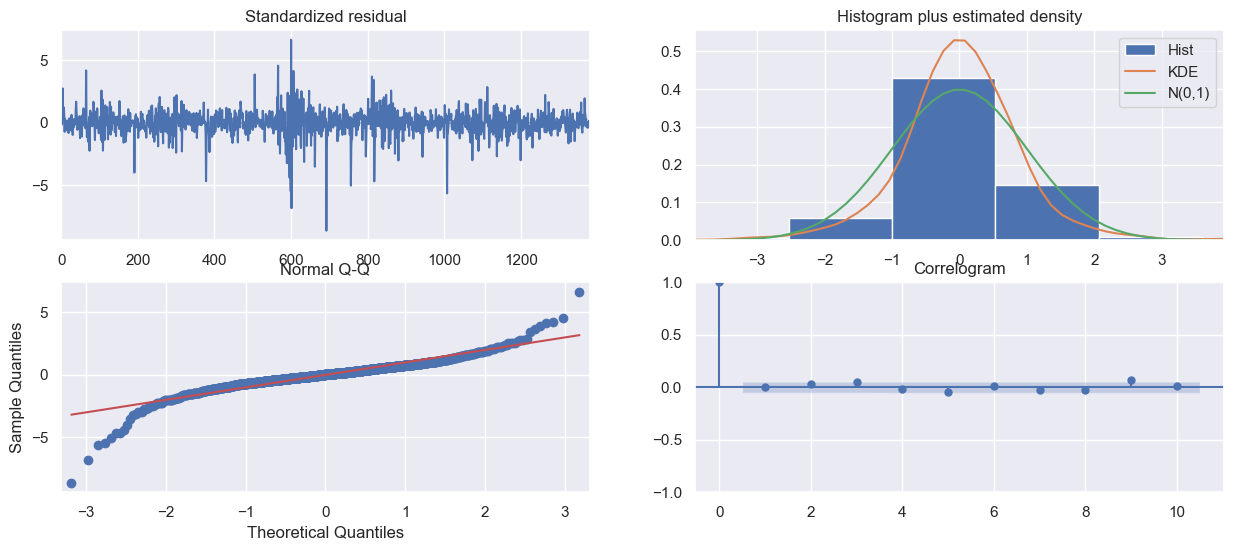

In [36]:
arima_model.plot_diagnostics(figsize=(15, 6))
plt.show()

В суммарном отчете показателей модели изучаем информационные критерии, например, критерий Акаике (AIC): чем он меньше, чем меньше потери информации при обучении.\
На графиках диагностики смотрим распределение остатков, хорошо если его можно назвать нормальным или приближенным к нормальному, а коррелограмме изучаем зависимости, если все лаги близки к нулю, то между остатками отсутствует корреляция (ошибки независимы).

Давайте попробуем сделать прогноз на будущие даты, для примера спрогнозируем текущую стоимость акции и поведение на следующий рабочий месяц.

In [37]:
# в функцию подаем начальную даты (по умолчанию сегодня) и количество дней, на какой период хотим сделать предсказание
def get_exog(start_date=datetime.now(), days=30):
    # прогнозируемый период - сколько дней наперед
    end_date = start_date + timedelta(days)
    # создаем временной ряд наперед, берем только рабочие дни, поэтому указываем частоту 'B' и метод bdate_range
    period = pd.bdate_range(start_date, end_date, freq='B')
    # формируем dataframe из созданного ряда
    data = pd.DataFrame({'Date': period})
    data['month'] = data['Date'].dt.month_name() # выделяем признак месяца
    data['week'] = data['Date'].dt.day_name()    # выделяем признак дня недели
    # применяем однократное кодирование
    data = pd.get_dummies(data)
    # дату устанавливаем в качестве индекса
    data.set_index('Date', inplace=True)
    # возвращаем сформированный dataframe и количество дней, которое хотим предсказать
    return data, len(period)

In [38]:
# применим функцию
exog_future, horizon = get_exog(start_date=datetime.now())
exog_future.head(3)

month_October  month_September  week_Friday  week_Monday  \
Date                                                                   
2024-09-04          False             True        False        False   
2024-09-05          False             True        False        False   
2024-09-06          False             True         True        False   

            week_Thursday  week_Tuesday  week_Wednesday  
Date                                                     
2024-09-04          False         False            True  
2024-09-05           True         False           False  
2024-09-06          False         False           False

In [39]:
# предсказываем на будущее, дата отсчета - сегодня
predictions = arima_model.predict(n_periods=horizon, X=exog_future, start_data=datetime.now())
# создаем датафрейм из предсказанных значений
df_future = pd.DataFrame({'Date': exog_future.index, 'Close': predictions.values})
df_future = df_future.set_index('Date')
df_future.head()

Close
Date                 
2024-09-04  31.920701
2024-09-05  31.865918
2024-09-06  31.898511
2024-09-09  31.888763
2024-09-10  31.876497

Визуализируем общую картину, включая и прогноз на будущее.

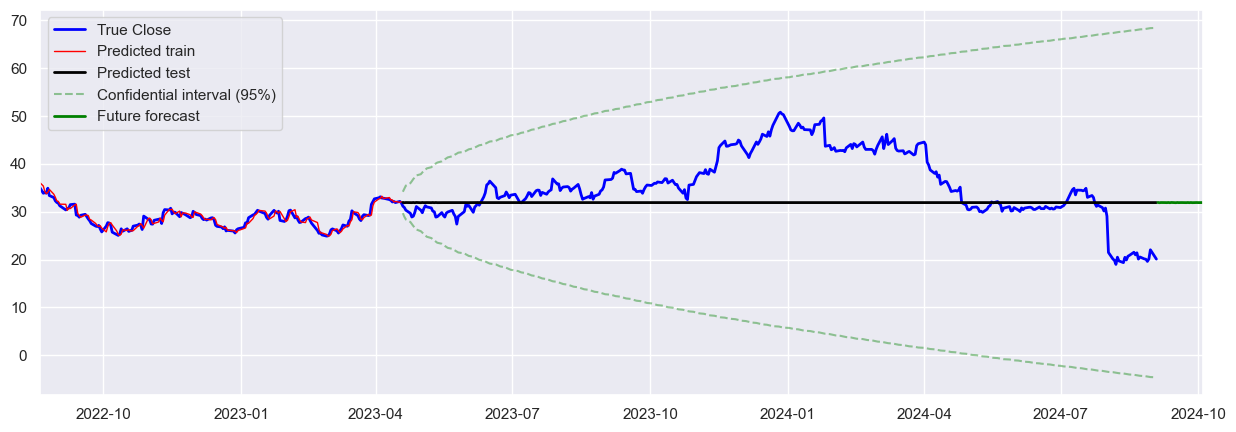

In [40]:
left = datetime(2022, 8, 20)
right = df_future.index[-1]
fig = plt.figure(figsize=(15,5))
plt.plot(stock_data.Close, color='blue', label='True Close', linewidth=2)
plt.plot(arima_model.fittedvalues(), color='red', label='Predicted train', linewidth=1)
plt.plot(forecast.predictions, color='black', label='Predicted test', linewidth=2)
plt.plot(forecast['conf_int_lower'], color='green', linestyle='--', alpha=0.4, label='Confidential interval (95%)')
plt.plot(forecast['conf_int_upper'], color='green', linestyle='--', alpha=0.4)
plt.plot(df_future, color='green', label='Future forecast', linewidth=2)
plt.legend()
plt.gca().set_xbound(left, right)
plt.savefig('images/Forecast ARIMA.png')
plt.show()

По графику мы понимаем, что полагаться на ARIMA для предсказания поведения акции нам не следует, осталось посмотреть текущее значение акции и убедиться в ошибке.

In [41]:
today_price = yf.Ticker(x).info['currentPrice']
print('Стоимость акции на сегодня: {}, прогноз: {}, абсолютная ошибка: {}%'.format(today_price, round(df_future.iloc[0], 2),\
      round(mean_absolute_percentage_error(np.array([today_price]), df_future.iloc[0])*100),2))

Стоимость акции на сегодня: 19.945, прогноз: Close    31.92
Name: 2024-09-04 00:00:00, dtype: float64, абсолютная ошибка: 60%


### 6.2 Волатильность (условная дисперсия) временного ряда.
Одна из самых важных характеристик финансовых активов - волатильность.
Волатильность определяется величиной и частотой колебания стоимости, бывает высокой, низкой. Высокая волатильность указывает на риск - высокие колебания цены, низкая отражает стабильное поведение стоимости акции. Модель ARIMA является гомоскедастической, когда между наблюдениями постоянная дисперсия во времени.

Чтобы смоделировать волатильность (в случае непостоянной дисперсии) применяется модель GARCH, которая является обобщенной авторегрессионной условной гетероскедастической моделью порядка (P,Q).

Формула расчета **Volatility** во времени **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

Чтобы измерить как дисперсия изменяется во времени, мы воспользуемся методом из pandas pct_change(), который рассчитывает изменение на единицу измерения (относительное изменение). Умножим на 100, чтобы перевести в проценты.

In [42]:
# аналогичный метод по формуле
# stock_data['Close_vol'] = ((stock_data['Close'] - stock_data['Close'].shift(1))/stock_data['Close'].shift(1) * 100)

# вячисляем относительное изменение дисперсии
stock_data['Close_vol'] = (stock_data['Close'].pct_change(1))*100
# заполним образовавшийся пропуск первого значения
stock_data['Close_vol'] = stock_data['Close_vol'].interpolate(method='bfill')
stock_data['Close_vol'].head()

Date
2017-10-20    0.989368
2017-10-23    0.989368
2017-10-24    0.293899
2017-10-25   -0.415145
2017-10-26    1.397743
Name: Close_vol, dtype: float64

Отобразим условную дисперсию на графике.

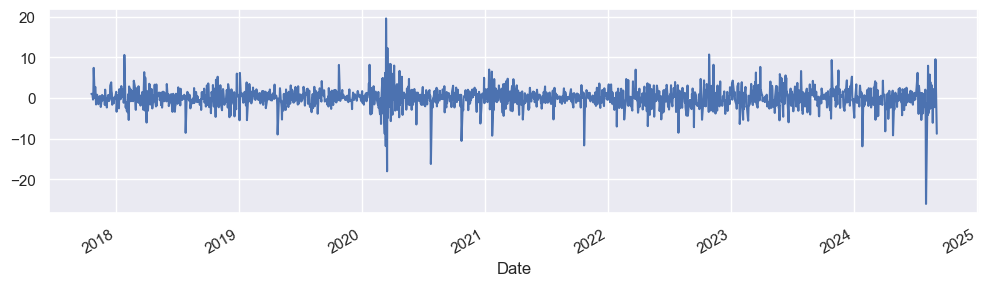

In [43]:
stock_data['Close_vol'].plot(figsize=(12,3));

Посмотрим графики автокорреляции и частичной корреляции. 

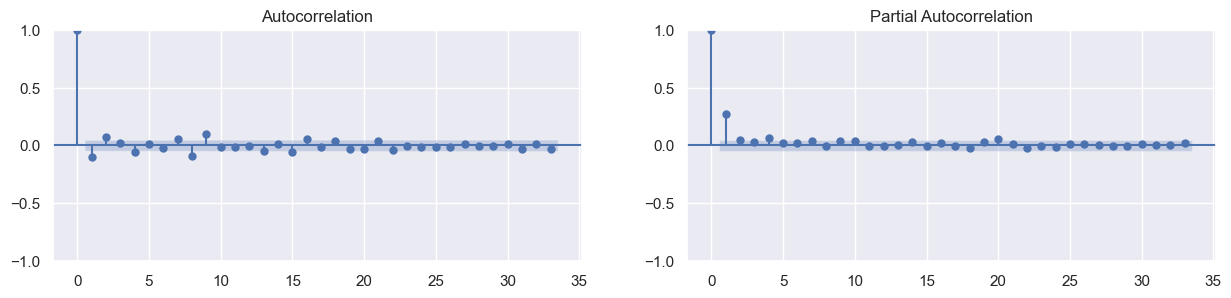

In [44]:
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(121)
# коррелограмма
sm.graphics.tsaplots.plot_acf(stock_data['Close_vol'], ax=ax1, alpha=0.05)

ax2 = fig.add_subplot(122)
# график частичной корреляции
sm.graphics.tsaplots.plot_pacf(stock_data['Close_vol']**2, ax=ax2, alpha=0.05)
plt.show()

Итак, на графике частичной автокорреляции самый значительный лаг выше уровня значимости равен 1, авторегрессионный порядок модели Garch p=1. Скользящее среднее q задает самый большой лаг на коррелограмме, который имеет высокую корреляцию для прогнозирования будущих значений. В нашем случае значением скользящего среднего возьмем 1 (предыдущее наблюдение).

Разделим данные на тренировочные и тестовые, используем прежнее соотношение 80/20.

In [45]:
index = int(len(stock_data[['Close_vol']]) * 0.8) 
train_vol = stock_data[['Close_vol']][0:index]
test_vol = stock_data[['Close_vol']][index:]
train_vol.shape, test_vol.shape

((1381, 1), (346, 1))

In [46]:
# строим модель и обучим на тренировочном наборе
garch_model = arch_model(train_vol, vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(last_obs=test_vol.index[0], update_freq=False)
garch_results.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3055.431226276696
            Iterations: 14
            Function evaluations: 83
            Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Close_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3055.43
Distribution:                  Normal   AIC:                           6118.86
Method:            Maximum Likelihood   BIC:                           6139.78
                                        No. Observations:                 1381
Date:                Wed, Sep 04 2024   Df Residuals:                     1380
Time:                        16:50:05   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0154  6.017e-02      0.256      0.798 [ -0.103,  0.133]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9886      0.605      1.635      0.102    [ -0.196,  2.174]
alpha[1]       0.0965  5.195e-02      1.858  6.310e-02 [-5.272e-03,  0.198]
beta[1]        0.7118      0.148      4.803  1.563e-06    [  0.421,  1.002]
===========================================================================

Covariance estimator: robust
"""

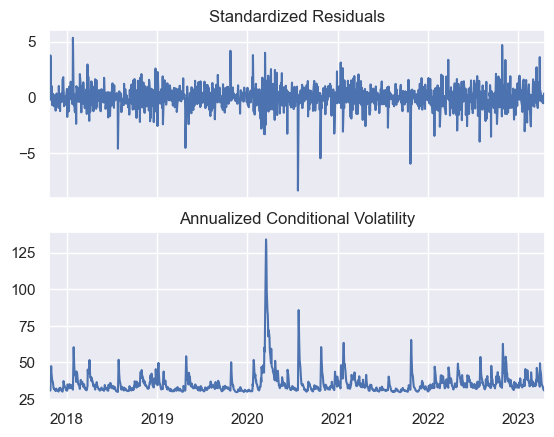

In [47]:
# визуализируем истинную и полученную волатильность на тренировочном наборе
garch_results.plot(annualize="D");

In [48]:
# создаем датафрейм из тестовой выборки, куда запишем предсказанные значения
predictions_df = test_vol.copy()
# делаем предсказание на количество наблюдений тестовой выборки
preds = garch_results.forecast(horizon=test_vol.shape[0], reindex=True) 
# сохраняем предсказанные значения в новый столбец скорированного датафрейма
predictions_df['Predicted Close_vol'] = np.sqrt(preds.variance.values[-1,:])
predictions_df.head()

Close_vol  Predicted Close_vol
Date                                      
2023-04-19  -2.136350             1.932157
2023-04-20  -0.930976             2.001567
2023-04-21  -1.814651             2.055960
2023-04-24  -2.112209             2.098897
2023-04-25  -2.629807             2.132972

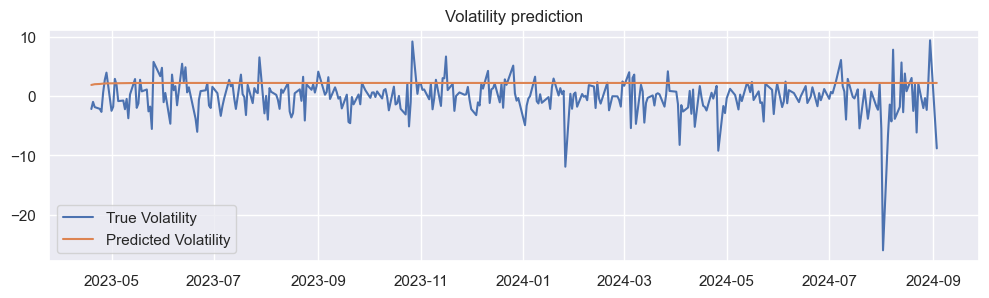

In [49]:
# отобразим предсказанныую волатильность на тестовой выборке
fig,ax = plt.subplots(figsize=(12,3))
plt.plot(predictions_df['Close_vol']) # истинная волатильность
plt.plot(predictions_df['Predicted Close_vol']) # предсказанная волатильность
plt.title('Volatility prediction')
plt.legend(['True Volatility', 'Predicted Volatility'])
plt.show()

Абсолютно мимо. Мы попробуем тот же принцип скользящего среденего, на котором построенны многие модели временных рядов, применить для предсказания волатильности на основе усреднения математического ожидания за определенный период.\
Скользящий прогноз на один шаг вперед. Потом обновляем информацию: время t становится временем t+1, t+2 и т.д. и вновь моделируем на один шаг вперед.

In [50]:
# создаем пустой список. куда будем записывать предсказанное одно значение
ma_predictions = []

for i in range(test_vol.shape[0]):
    # последовательно обучаем временной ряд из тренировочной выборки, каждый раз добавляя по одному предсказанию из тестовой выборки
    train = stock_data[['Close_vol']][:-(test_vol.shape[0] - i)]
    model = arch_model(train, p=1, q=1)
    # обучаем
    fit_model = model.fit(disp='off')                             # итерации обучения не выводим
    pred = fit_model.forecast(horizon=1, reindex=True)            # предсказываем одно значение
    # добавляем в список предсказанное значение, так как возвращается массив, указываем индекс, для получения этого значения
    ma_predictions.append(np.sqrt(pred.variance.values[-1,:][0])) 
# запишем все предсказанные значения в series и укажем индексы нашей тестового набора
ma_predictions = pd.Series(ma_predictions, index=test_vol.index)

Давайте отобразим волатильность, которую мы получили с помощью последовательного сглаживания

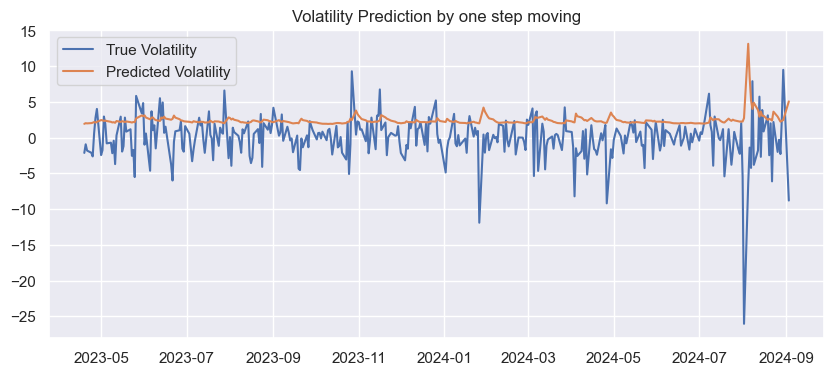

In [51]:
plt.figure(figsize=(10,4))
true, = plt.plot(predictions_df['Close_vol'], label='True Volatility')
preds, = plt.plot(ma_predictions, label='Predicted Volatility')
plt.title('Volatility Prediction by one step moving')
plt.legend()
plt.show()

Мы получили неплохой результат, смены периодов волатильности мы уловили.

### 6.3 XGBoost model
Для прогнозирования целевой переменной - стоимости акции на момент закрытия мы используем сгенерированные нами признаки: индексы RSI, MACD и значения экспоненциальных и простых скользящих средних нашего временного ряда.

In [52]:
stock_data.columns

Index(['Close', 'Diff', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September', 'week_Friday', 'week_Monday', 'week_Thursday',
       'week_Tuesday', 'week_Wednesday', 'Close_diff', 'EMA_9', 'EMA_14',
       'MA_5', 'MA_9', 'MA_15', 'MA_30', 'RSI', 'MACD', 'MACD_signal',
       'Close_vol'],
      dtype='object')

Удаляем все столбы, кроме необходимых для моделирования.

In [53]:
stock_data = stock_data.drop(['Diff', 'Close_diff', 'Close_vol', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June', 'month_March', 'month_May', 'month_November', 
       'month_October', 'month_September'], axis=1).copy()

Разделим данные на тренировочную и тестовую выборки

In [54]:
index = int(len(stock_data) * 0.8)
X_train = stock_data.drop(['Close'], axis=1).iloc[0:index]
y_train = stock_data['Close'].iloc[0:index]

X_test = stock_data.drop(['Close'], axis=1).iloc[index:]
y_test = stock_data['Close'].iloc[index:]

X_train.shape, X_test.shape

((1381, 14), (346, 14))

Чтобы создать оптимальную модель, обратимся к помощнику, которые переберет алгоритмы с разными гиперпараметрами и вернет наилучший из них, в этом нам поможет оптимизатор из библиотеки scikit-learn GridSearchCV. Алгоритм возвращает уже обученную модель на лучших гиперпараметрах их заданной сетки.

In [55]:
# задаем сетку гиперпараметров для перебора
params = {
    'n_estimators': [500, 1000, 2000],                # количество моделей - деревьев
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],  # темп обучения
    'max_depth': [10, 15, 20],                        # максимальная глубина дерева
    'gamma': [0.02, 0.04, 0.06]                       # минимальное изменение значения loss функции для разделения листа на поддеревья
}

# добавим early_stopping_round - модель останавливается после числа прямых ухудшений 
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=3)
# передаем модель и параметры в оптимизатор, выведение итераций отключим (verbose=False), зададим метрику mape
xgb_model = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

%time
# обучаем
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
# выведем оптимальные гиперпараметры для нашей модели и значение mape на тренировочном наборе, полученное в процессе кросс-валидации
print(f'Best params: {xgb_model.best_params_}')
print(f'Best validation score = {-xgb_model.best_score_*100}')

CPU times: total: 0 ns
Wall time: 0 ns
Best params: {'gamma': 0.02, 'learning_rate': 0.04, 'max_depth': 15, 'n_estimators': 500}
Best validation score = 7.222037236620311


In [56]:
# предсказываем значения для тестового набора
xg_predictions = xgb_model.predict(X_test)
# посмотрим на среднюю абсолютную ошибку в процентах
print('Средняя абсолютная ошибка в процентах:', round(mean_absolute_percentage_error(y_test, xg_predictions)*100,2))

xg_predictions = pd.DataFrame(xg_predictions, index=X_test.index)
df_prediction = pd.concat([y_test, pd.DataFrame(xg_predictions)], axis=1)
df_prediction.columns = ['True Close', 'Predicted Close']
df_prediction.head(10).style.format(precision=2)

Средняя абсолютная ошибка в процентах: 4.69


Визуализируем предсказанные значения Close

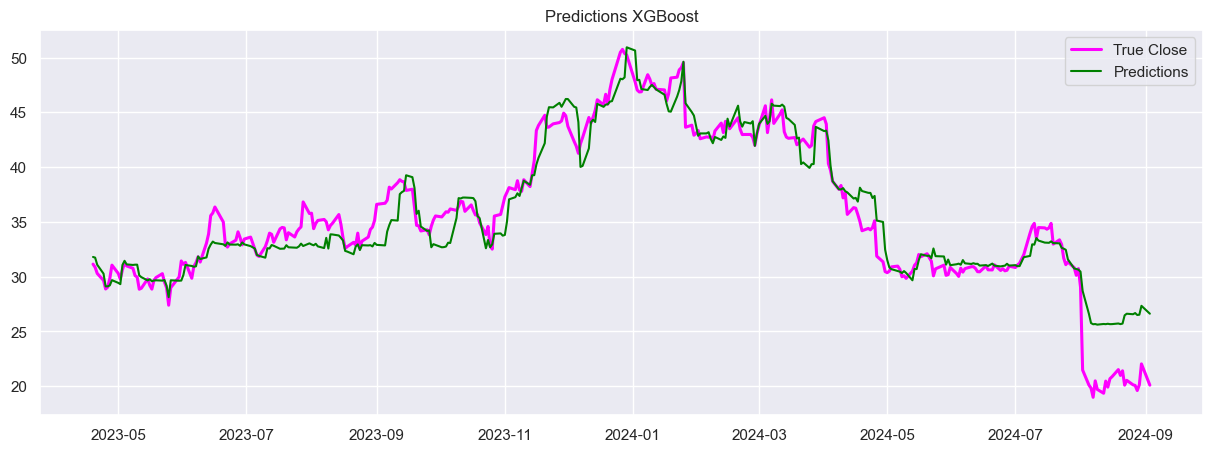

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(y_test, color='magenta', linewidth=2.2)
plt.plot(xg_predictions, color='green', linewidth=1.5)
plt.legend(['True Close', 'Predictions'])
plt.title('Predictions XGBoost')
plt.savefig('images/Predictions XGBoost.png')
plt.show()

В конце модель спрогнозировала менее резкое падение, чем по факту, это как раз и отражает суть, что на волатильность активов влияют внешние события и важно не только смотреть на прогноз, но быть в курсе всей аналитики по компании и событий на мировом рынке.

Отобразим важность признаков для прогнозирования

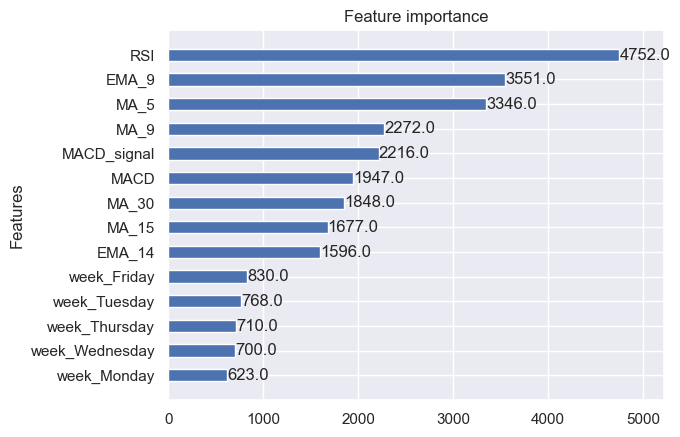

In [58]:
params = xgb_model.best_params_
model_ = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=3, 
                          gamma=params['gamma'], learning_rate=params['learning_rate'],
                          max_depth=params['max_depth'], n_estimators=params['n_estimators'])
model_ = model_.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
xgb.plot_importance(model_, xlabel='', height=0.5);

### 6.4 Neuralprophet

Библиотека NeuralProphet, основанная на PyTorch, является недавно созданным удобным инструментом для прогнозирования временных рядов с автоматическим подбором гиперпараметров и встроенной визуализацией.

По умолчанию объект NeuralProphet принимает два признака: даты, которые необходимо переименовать в столбец 'ds' и значения для предсказания с именем 'y'.

In [59]:
# создаем датафрейм с нужными параметрами
df_close = pd.DataFrame({'ds': stock_data.index, 'y': stock_data.Close})
df_close.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1727 entries, 2017-10-20 to 2024-09-03
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1727 non-null   datetime64[ns]
 1   y       1727 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.5 KB


In [60]:
set_random_seed(seed=42)
set_log_level("ERROR")

In [61]:
# создаем экземпляр класса NeuralProphet
prophet = NeuralProphet(
    growth='off',                   # тип роста тренда
    loss_func='MSE',                # тип функции потерь
    yearly_seasonality='auto',      # ежегодный характер сезонности и последующие отдадим на автоподбор
    weekly_seasonality='auto',                     
    daily_seasonality='auto',                    
    learning_rate=0.07,             # темп обучения                  
    epochs=500,                     # количество итераций
    future_regressors_model='neural_nets',
    future_regressors_d_hidden=3,   # количество внутренних слоев нейросети
    n_lags=1,                       # порядок авторегрессии
    collect_metrics=["MSE", "MAE"],  # параметры для вычисления    
    n_forecasts=1,
    drop_missing=True          
)
prophet.set_plotting_backend("plotly")
# используем специальную функцию библиотеки для разделения данных на тренировочную и тестовую выборки
train, test = prophet.split_df(df_close, freq='D', valid_p = 0.2)
# обучаем тестовый набор, добавим ранюю остановку, если далее снижение функции потерь не происходит
metrics_train = prophet.fit(train, freq='D', validation_df=test, metrics=True, early_stopping=True)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [62]:
# предсказываем
prophet_predictions = prophet.predict(test)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [63]:
print('Средняя абсолютная ошибка: {}%'\
      .format(round(mean_absolute_percentage_error(prophet_predictions['y'].iloc[1:], prophet_predictions['yhat1'].iloc[1:])*100,2)))

Средняя абсолютная ошибка: 1.54%


Напишем функцию для предсказания движения акции на следующий месяц, в качестве обучения в этом случае мы используем весь набор, чтобы модель обладала большей информативностью.\
Функция принимает датасет и n - число дней, которое мы хотим предсказать:
* В предсказание используется принцип скользящего среднего с одним запаздыванием, как мы уже делали ранее для волатильности.\
Мы предсказываем на один шаг (один день), добавляем это значение в исторические данные и вновь предсказываем на шаг вперед.
* Функция возвращает датасет forecast с историческими истинными значениями и предсказанными, который мы визуализируем.


In [64]:
def make_prediction(data, n):
    for i in range(n):
        future_df = prophet.make_future_dataframe(data, periods=10, n_historic_predictions=len(data))
        forecast = prophet.predict(future_df)
        period = pd.DataFrame(data={"ds": pd.bdate_range(start=data["ds"].tail(1).values[0], periods=2, freq="B"), "y": np.NaN})
        data = pd.concat([data, period], axis=0).drop_duplicates(subset='ds').reset_index().drop('index', axis=1)
        data['y'].iloc[-1] = forecast['yhat1'].iloc[-1]
    return forecast

In [65]:
forecast = make_prediction(df_close, n=10)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [66]:
idx = forecast[forecast['ds']==df_close['ds'].iloc[-1]].index[0]
forecast['y'].iloc[idx+1:] = np.NaN
forecast.tail(15)

ds     y      yhat1        ar1      trend  season_yearly  \
2510 2024-09-03  20.1  20.744688 -23.900032  47.124084      -2.553546   
2511 2024-09-04   NaN  20.416176 -24.441151  47.124084      -2.554163   
2512 2024-09-05   NaN  20.197680 -24.338018  47.124084      -2.551405   
2513 2024-09-06   NaN  20.314251 -24.235321  47.124084      -2.545678   
2514 2024-09-07   NaN  20.407450 -24.133057  47.124084      -2.537353   
2515 2024-09-08   NaN  20.243643 -24.093098  47.124084      -2.527061   
2516 2024-09-09   NaN  20.761532 -23.859255  47.124084      -2.514986   
2517 2024-09-10   NaN  20.585495 -24.111166  47.124084      -2.501630   
2518 2024-09-11   NaN  20.914375 -24.009426  47.124084      -2.487490   
2519 2024-09-12   NaN  20.705809 -23.908117  47.124084      -2.472998   
2520 2024-09-13   NaN  20.829044 -23.807234  47.124084      -2.458773   
2521 2024-09-14   NaN  20.926016 -23.706778  47.124084      -2.444867   
2522 2024-09-15   NaN  20.760571 -23.671120  47.124084      -2.431967   
2523 2024-09-16   NaN  21.276093 -23.438677  47.124084      -2.420541   
2524 2024-09-17   NaN  21.099363 -23.688374  47.124084      -2.410537   

      season_weekly  
2510       0.074182  
2511       0.287408  
2512      -0.036980  
2513      -0.028835  
2514      -0.046223  
2515      -0.260282  
2516       0.011690  
2517       0.074207  
2518       0.287208  
2519      -0.037160  
2520      -0.029032  
2521      -0.046424  
2522      -0.260425  
2523       0.011226  
2524       0.074189

Визуализируем результат, используя встроенные инструменты библиотеки.

In [67]:
prophet.plot(forecast, figsize=(15,7), plotting_backend='plotly')

Посмотрим на цикличность нашего ряда, это очень полезный инструмент библиотеки, который подскажет, когда покупать и продавать акции. Данный график знакомит нас с периодами роста или снижения стоимости актива по месяцам и дням недели.

In [68]:
prophet.plot_parameters(figsize=(15,3), plotting_backend='plotly')

Визуализируем значения прогнозов модели NeuralProphet и сохраним график.

In [69]:
# отобразим на графике
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_close.ds.iloc[1100:], y=df_close.y.iloc[1100:], name='True Close', line=dict(color='magenta', width=3)))
fig.add_trace(go.Scatter(x=prophet_predictions.ds, y=prophet_predictions.yhat1, name='Predicted Close test', line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=forecast.ds.iloc[1600:], y=forecast.yhat1.iloc[1600:], name='Forecast Close', line=dict(color='black', width=1)))

fig.update_layout(
    title={'text': f'Forecast NeuralProphet','x':0.5,'xanchor': 'center', 'yanchor': 'top'}, 
    width=1050, height=500,
    autosize=False, margin=dict(t=30, b=60, l=30, r=10),
    template="plotly",
    legend=dict(yanchor="bottom", y=-0.2, orientation='h', xanchor="right", x=0.9)
    )
fig.write_image('images/Forecast NeuralProphet.png')
iplot(fig)

## Заключение
1. Предсказывать временной ряд биржевых активов, используя только технический подход, дело интересное, но рискованное, мы не можем полагаться только на зависимости в исторической "ретроспективе", изучении характеристик ряда как тренд, цикличность, волатильность, для прогноза, потому что мы должны исследовать финансовую и аналитическую отчетность компании. Это даст нам более полную картину для долгосрочного инвестирования.
2. Всегда каждый трейдер начинает свой день с новостей политики, экономики и многих других событий мирового рынка, потому что он понимает, как влияют события на поведение котировок, активов и любых других изменений на бирже.
3. Автор данного исследования уже упонимал о полном отсутствии каких-либо знаний в области рынка ценных бумаг, трейдинга и всей этой "галактики" финансого мира, но как дата-сайнтисту, ему необходимы исторические данные и цель, чего он хочет достичь, а далее он уже погружается в мир анализа зависимостей, поиска лучших решений для построения эффективного алгоритма. Поэтому данный проект нужно рассматривать не как экспертное мнение, а как дополнительный инструмент-помощник на пути трейдинга и инвестирования.
4. Самой эффективной моделью оказалась NeuralProphet, молодая библиотека на основе нейронных сетей. Кажется на этом примере уже можно говорить о ее перспективе на рынке алгоритмов ML.

Автор: Ярослава Вобшаркян\
(студент школы SkillFactory по курсу Data Science)\
27.08.2024